### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 600
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 15  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")



Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:01<85:08:01, 61.31s/it]

Entrenando:   0%|          | 2/5000 [02:08<89:33:52, 64.51s/it]

Entrenando:   0%|          | 3/5000 [03:17<92:52:21, 66.91s/it]

Entrenando:   0%|          | 4/5000 [04:16<88:23:04, 63.69s/it]

Entrenando:   0%|          | 5/5000 [05:23<89:57:15, 64.83s/it]

Entrenando:   0%|          | 6/5000 [06:23<87:30:05, 63.08s/it]

Entrenando:   0%|          | 7/5000 [07:25<87:23:04, 63.01s/it]

Entrenando:   0%|          | 8/5000 [08:30<87:58:42, 63.45s/it]

Entrenando:   0%|          | 9/5000 [09:33<87:53:22, 63.39s/it]

Entrenando:   0%|          | 10/5000 [10:36<87:46:36, 63.33s/it]

Entrenando:   0%|          | 11/5000 [11:39<87:41:43, 63.28s/it]

Entrenando:   0%|          | 12/5000 [12:47<89:16:06, 64.43s/it]

Entrenando:   0%|          | 13/5000 [13:53<90:11:11, 65.10s/it]

Entrenando:   0%|          | 14/5000 [15:21<99:46:02, 72.03s/it]

Entrenando:   0%|          | 15/5000 [17:16<117:24:33, 84.79s/it]

Entrenando:   0%|          | 16/5000 [19:06<127:57:57, 92.43s/it]

Entrenando:   0%|          | 17/5000 [20:49<132:36:10, 95.80s/it]

Entrenando:   0%|          | 18/5000 [22:38<138:03:51, 99.77s/it]

Entrenando:   0%|          | 19/5000 [24:22<139:45:49, 101.01s/it]

Entrenando:   0%|          | 20/5000 [26:04<140:11:09, 101.34s/it]

Entrenando:   0%|          | 21/5000 [27:54<143:40:01, 103.88s/it]

Entrenando:   0%|          | 22/5000 [29:33<141:31:20, 102.35s/it]

Entrenando:   0%|          | 23/5000 [31:17<142:00:58, 102.72s/it]

Entrenando:   0%|          | 24/5000 [33:02<143:06:55, 103.54s/it]

Entrenando:   0%|          | 25/5000 [34:46<143:15:25, 103.66s/it]

Entrenando:   1%|          | 26/5000 [36:35<145:34:45, 105.36s/it]

Entrenando:   1%|          | 27/5000 [38:59<161:30:37, 116.92s/it]

Entrenando:   1%|          | 28/5000 [41:17<170:12:55, 123.25s/it]

Entrenando:   1%|          | 29/5000 [43:34<175:53:03, 127.38s/it]

Entrenando:   1%|          | 30/5000 [45:57<182:08:36, 131.94s/it]

Entrenando:   1%|          | 31/5000 [48:18<185:44:42, 134.57s/it]

Entrenando:   1%|          | 32/5000 [50:40<188:55:11, 136.90s/it]

Entrenando:   1%|          | 33/5000 [53:03<191:29:40, 138.79s/it]

Entrenando:   1%|          | 34/5000 [55:28<194:05:46, 140.71s/it]

Entrenando:   1%|          | 35/5000 [57:54<196:06:01, 142.19s/it]

Entrenando:   1%|          | 36/5000 [1:00:10<193:33:17, 140.37s/it]

Entrenando:   1%|          | 37/5000 [1:02:36<195:59:36, 142.17s/it]

Entrenando:   1%|          | 38/5000 [1:04:53<193:43:04, 140.55s/it]

Entrenando:   1%|          | 39/5000 [1:07:20<196:15:38, 142.42s/it]

Entrenando:   1%|          | 40/5000 [1:09:36<193:24:33, 140.38s/it]

Entrenando:   1%|          | 41/5000 [1:11:50<190:51:43, 138.56s/it]

Entrenando:   1%|          | 42/5000 [1:14:08<190:34:43, 138.38s/it]

Entrenando:   1%|          | 43/5000 [1:16:24<189:50:43, 137.87s/it]

Entrenando:   1%|          | 44/5000 [1:18:41<189:09:10, 137.40s/it]

Entrenando:   1%|          | 45/5000 [1:20:56<188:14:49, 136.77s/it]

Entrenando:   1%|          | 46/5000 [1:23:10<187:11:57, 136.04s/it]

Entrenando:   1%|          | 47/5000 [1:25:26<186:53:05, 135.83s/it]

Entrenando:   1%|          | 48/5000 [1:27:35<184:14:16, 133.94s/it]

Entrenando:   1%|          | 49/5000 [1:29:46<183:03:04, 133.10s/it]

Entrenando:   1%|          | 50/5000 [1:32:01<183:37:38, 133.55s/it]

Iter  50: train_loss=4.2931, val_loss=4.1699, train_suc=0.357, train_err=0.179, train_inc=0.465 | val_suc=0.375, val_err=0.177, val_inc=0.448


Entrenando:   1%|          | 51/5000 [1:34:05<179:40:16, 130.70s/it]

Entrenando:   1%|          | 52/5000 [1:35:50<169:06:11, 123.03s/it]

Entrenando:   1%|          | 53/5000 [1:37:37<162:23:35, 118.18s/it]

Entrenando:   1%|          | 54/5000 [1:39:18<155:14:22, 112.99s/it]

Entrenando:   1%|          | 55/5000 [1:40:56<148:54:54, 108.41s/it]

Entrenando:   1%|          | 56/5000 [1:42:41<147:33:44, 107.45s/it]

Entrenando:   1%|          | 57/5000 [1:44:31<148:42:15, 108.30s/it]

Entrenando:   1%|          | 58/5000 [1:46:20<148:58:34, 108.52s/it]

Entrenando:   1%|          | 59/5000 [1:48:07<148:16:13, 108.03s/it]

Entrenando:   1%|          | 60/5000 [1:50:05<152:08:04, 110.87s/it]

Entrenando:   1%|          | 61/5000 [1:51:46<148:17:39, 108.09s/it]

Entrenando:   1%|          | 62/5000 [1:53:28<145:41:29, 106.22s/it]

Entrenando:   1%|▏         | 63/5000 [1:55:06<142:23:05, 103.83s/it]

Entrenando:   1%|▏         | 64/5000 [1:56:45<140:15:40, 102.30s/it]

Entrenando:   1%|▏         | 65/5000 [1:58:18<136:19:43, 99.45s/it] 

Entrenando:   1%|▏         | 66/5000 [1:59:54<134:56:06, 98.45s/it]

Entrenando:   1%|▏         | 67/5000 [2:01:32<134:39:17, 98.27s/it]

Entrenando:   1%|▏         | 68/5000 [2:03:05<132:34:13, 96.77s/it]

Entrenando:   1%|▏         | 69/5000 [2:04:49<135:24:44, 98.86s/it]

Entrenando:   1%|▏         | 70/5000 [2:06:25<134:07:08, 97.94s/it]

Entrenando:   1%|▏         | 71/5000 [2:07:58<132:07:17, 96.50s/it]

Entrenando:   1%|▏         | 72/5000 [2:09:42<135:05:27, 98.69s/it]

Entrenando:   1%|▏         | 73/5000 [2:11:16<133:25:12, 97.49s/it]

Entrenando:   1%|▏         | 74/5000 [2:12:51<132:14:43, 96.65s/it]

Entrenando:   2%|▏         | 75/5000 [2:14:22<129:49:46, 94.90s/it]

Entrenando:   2%|▏         | 76/5000 [2:15:53<128:27:27, 93.92s/it]

Entrenando:   2%|▏         | 77/5000 [2:17:25<127:19:49, 93.11s/it]

Entrenando:   2%|▏         | 78/5000 [2:18:53<125:35:08, 91.85s/it]

Entrenando:   2%|▏         | 79/5000 [2:20:18<122:38:08, 89.72s/it]

Entrenando:   2%|▏         | 80/5000 [2:21:41<119:57:19, 87.77s/it]

Entrenando:   2%|▏         | 81/5000 [2:23:06<118:45:49, 86.92s/it]

Entrenando:   2%|▏         | 82/5000 [2:24:31<117:52:59, 86.29s/it]

Entrenando:   2%|▏         | 83/5000 [2:25:55<116:58:59, 85.65s/it]

Entrenando:   2%|▏         | 84/5000 [2:27:24<117:59:04, 86.40s/it]

Entrenando:   2%|▏         | 85/5000 [2:28:39<113:36:14, 83.21s/it]

Entrenando:   2%|▏         | 86/5000 [2:29:54<110:11:23, 80.73s/it]

Entrenando:   2%|▏         | 87/5000 [2:31:13<109:17:11, 80.08s/it]

Entrenando:   2%|▏         | 88/5000 [2:32:29<107:34:35, 78.84s/it]

Entrenando:   2%|▏         | 89/5000 [2:33:45<106:32:52, 78.10s/it]

Entrenando:   2%|▏         | 90/5000 [2:35:02<105:54:31, 77.65s/it]

Entrenando:   2%|▏         | 91/5000 [2:36:17<104:56:47, 76.96s/it]

Entrenando:   2%|▏         | 92/5000 [2:37:30<103:10:44, 75.68s/it]

Entrenando:   2%|▏         | 93/5000 [2:38:38<100:12:50, 73.52s/it]

Entrenando:   2%|▏         | 94/5000 [2:39:49<98:53:43, 72.57s/it] 

Entrenando:   2%|▏         | 95/5000 [2:41:01<98:51:17, 72.55s/it]

Entrenando:   2%|▏         | 96/5000 [2:42:17<100:00:55, 73.42s/it]

Entrenando:   2%|▏         | 97/5000 [2:43:24<97:35:49, 71.66s/it] 

Entrenando:   2%|▏         | 98/5000 [2:44:34<96:57:20, 71.20s/it]

Entrenando:   2%|▏         | 99/5000 [2:45:49<98:15:40, 72.18s/it]

Entrenando:   2%|▏         | 100/5000 [2:47:02<98:33:26, 72.41s/it]

Iter 100: train_loss=2.2287, val_loss=2.1730, train_suc=0.414, train_err=0.035, train_inc=0.551 | val_suc=0.432, val_err=0.036, val_inc=0.531
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [2:48:08<96:11:34, 70.69s/it]

Entrenando:   2%|▏         | 102/5000 [2:49:18<95:53:17, 70.48s/it]

Entrenando:   2%|▏         | 103/5000 [2:50:27<94:59:05, 69.83s/it]

Entrenando:   2%|▏         | 104/5000 [2:51:34<93:59:58, 69.12s/it]

Entrenando:   2%|▏         | 105/5000 [2:52:48<95:48:19, 70.46s/it]

Entrenando:   2%|▏         | 106/5000 [2:53:59<96:00:38, 70.62s/it]

Entrenando:   2%|▏         | 107/5000 [2:55:11<96:35:17, 71.06s/it]

Entrenando:   2%|▏         | 108/5000 [2:56:21<96:02:46, 70.68s/it]

Entrenando:   2%|▏         | 109/5000 [2:57:33<96:47:02, 71.24s/it]

Entrenando:   2%|▏         | 110/5000 [2:58:46<97:34:28, 71.83s/it]

Entrenando:   2%|▏         | 111/5000 [3:00:06<100:38:27, 74.11s/it]

Entrenando:   2%|▏         | 112/5000 [3:01:15<98:36:56, 72.63s/it] 

Entrenando:   2%|▏         | 113/5000 [3:02:20<95:20:08, 70.23s/it]

Entrenando:   2%|▏         | 114/5000 [3:03:30<95:29:00, 70.35s/it]

Entrenando:   2%|▏         | 115/5000 [3:04:39<94:47:15, 69.85s/it]

Entrenando:   2%|▏         | 116/5000 [3:05:39<90:47:43, 66.93s/it]

Entrenando:   2%|▏         | 117/5000 [3:06:50<92:38:43, 68.30s/it]

Entrenando:   2%|▏         | 118/5000 [3:08:02<93:45:05, 69.13s/it]

Entrenando:   2%|▏         | 119/5000 [3:09:13<94:38:29, 69.80s/it]

Entrenando:   2%|▏         | 120/5000 [3:10:20<93:28:31, 68.96s/it]

Entrenando:   2%|▏         | 121/5000 [3:11:32<94:52:08, 70.00s/it]

Entrenando:   2%|▏         | 122/5000 [3:12:47<96:51:53, 71.49s/it]

Entrenando:   2%|▏         | 123/5000 [3:14:00<97:15:41, 71.79s/it]

Entrenando:   2%|▏         | 124/5000 [3:15:06<95:06:16, 70.22s/it]

Entrenando:   2%|▎         | 125/5000 [3:16:14<93:53:39, 69.34s/it]

Entrenando:   3%|▎         | 126/5000 [3:17:23<93:48:25, 69.29s/it]

Entrenando:   3%|▎         | 127/5000 [3:18:27<91:46:34, 67.80s/it]

Entrenando:   3%|▎         | 128/5000 [3:19:37<92:36:47, 68.43s/it]

Entrenando:   3%|▎         | 129/5000 [3:20:51<95:02:47, 70.25s/it]

Entrenando:   3%|▎         | 130/5000 [3:22:04<95:48:40, 70.83s/it]

Entrenando:   3%|▎         | 131/5000 [3:23:06<92:22:35, 68.30s/it]

Entrenando:   3%|▎         | 132/5000 [3:24:17<93:17:38, 68.99s/it]

Entrenando:   3%|▎         | 133/5000 [3:25:33<96:20:14, 71.26s/it]

Entrenando:   3%|▎         | 134/5000 [3:26:43<95:32:01, 70.68s/it]

Entrenando:   3%|▎         | 135/5000 [3:27:52<95:10:48, 70.43s/it]

Entrenando:   3%|▎         | 136/5000 [3:29:05<96:02:01, 71.08s/it]

Entrenando:   3%|▎         | 137/5000 [3:30:19<97:00:01, 71.81s/it]

Entrenando:   3%|▎         | 138/5000 [3:31:29<96:33:14, 71.49s/it]

Entrenando:   3%|▎         | 139/5000 [3:32:38<95:14:59, 70.54s/it]

Entrenando:   3%|▎         | 140/5000 [3:33:49<95:39:32, 70.86s/it]

Entrenando:   3%|▎         | 141/5000 [3:34:59<95:05:45, 70.46s/it]

Entrenando:   3%|▎         | 142/5000 [3:36:07<94:16:52, 69.87s/it]

Entrenando:   3%|▎         | 143/5000 [3:37:18<94:41:41, 70.19s/it]

Entrenando:   3%|▎         | 144/5000 [3:38:27<93:57:33, 69.66s/it]

Entrenando:   3%|▎         | 145/5000 [3:39:39<95:08:57, 70.55s/it]

Entrenando:   3%|▎         | 146/5000 [3:40:45<93:02:21, 69.00s/it]

Entrenando:   3%|▎         | 147/5000 [3:41:56<93:49:30, 69.60s/it]

Entrenando:   3%|▎         | 148/5000 [3:43:05<93:44:16, 69.55s/it]

Entrenando:   3%|▎         | 149/5000 [3:44:17<94:46:44, 70.34s/it]

Entrenando:   3%|▎         | 150/5000 [3:45:23<93:03:50, 69.08s/it]

Iter 150: train_loss=1.8250, val_loss=1.6730, train_suc=0.441, train_err=0.004, train_inc=0.555 | val_suc=0.461, val_err=0.004, val_inc=0.535


Entrenando:   3%|▎         | 151/5000 [3:46:33<93:28:06, 69.39s/it]

Entrenando:   3%|▎         | 152/5000 [3:47:49<95:46:47, 71.12s/it]

Entrenando:   3%|▎         | 153/5000 [3:48:57<94:50:37, 70.44s/it]

Entrenando:   3%|▎         | 154/5000 [3:50:09<95:06:34, 70.66s/it]

Entrenando:   3%|▎         | 155/5000 [3:51:16<93:51:07, 69.74s/it]

Entrenando:   3%|▎         | 156/5000 [3:52:31<95:47:40, 71.19s/it]

Entrenando:   3%|▎         | 157/5000 [3:53:43<96:02:49, 71.40s/it]

Entrenando:   3%|▎         | 158/5000 [3:54:48<93:34:35, 69.57s/it]

Entrenando:   3%|▎         | 159/5000 [3:55:50<90:28:53, 67.29s/it]

Entrenando:   3%|▎         | 160/5000 [3:56:52<88:17:22, 65.67s/it]

Entrenando:   3%|▎         | 161/5000 [3:58:05<91:06:18, 67.78s/it]

Entrenando:   3%|▎         | 162/5000 [3:59:18<93:12:24, 69.36s/it]

Entrenando:   3%|▎         | 163/5000 [4:00:30<94:35:29, 70.40s/it]

Entrenando:   3%|▎         | 164/5000 [4:01:40<94:05:13, 70.04s/it]

Entrenando:   3%|▎         | 165/5000 [4:02:56<96:30:14, 71.85s/it]

Entrenando:   3%|▎         | 166/5000 [4:04:14<99:06:03, 73.80s/it]

Entrenando:   3%|▎         | 167/5000 [4:05:28<99:08:18, 73.85s/it]

Entrenando:   3%|▎         | 168/5000 [4:06:36<96:53:27, 72.19s/it]

Entrenando:   3%|▎         | 169/5000 [4:07:54<99:09:46, 73.89s/it]

Entrenando:   3%|▎         | 170/5000 [4:09:00<95:42:10, 71.33s/it]

Entrenando:   3%|▎         | 171/5000 [4:10:14<96:52:31, 72.22s/it]

Entrenando:   3%|▎         | 172/5000 [4:11:24<95:59:42, 71.58s/it]

Entrenando:   3%|▎         | 173/5000 [4:12:32<94:38:24, 70.58s/it]

Entrenando:   3%|▎         | 174/5000 [4:13:52<98:23:14, 73.39s/it]

Entrenando:   4%|▎         | 175/5000 [4:15:01<96:36:48, 72.08s/it]

Entrenando:   4%|▎         | 176/5000 [4:16:11<95:51:28, 71.54s/it]

Entrenando:   4%|▎         | 177/5000 [4:17:25<96:45:24, 72.22s/it]

Entrenando:   4%|▎         | 178/5000 [4:18:33<94:48:12, 70.78s/it]

Entrenando:   4%|▎         | 179/5000 [4:19:44<94:56:11, 70.89s/it]

Entrenando:   4%|▎         | 180/5000 [4:20:55<95:13:33, 71.12s/it]

Entrenando:   4%|▎         | 181/5000 [4:22:05<94:24:48, 70.53s/it]

Entrenando:   4%|▎         | 182/5000 [4:23:14<94:05:32, 70.31s/it]

Entrenando:   4%|▎         | 183/5000 [4:24:32<96:58:52, 72.48s/it]

Entrenando:   4%|▎         | 184/5000 [4:25:44<96:54:46, 72.44s/it]

Entrenando:   4%|▎         | 185/5000 [4:26:55<96:07:17, 71.87s/it]

Entrenando:   4%|▎         | 186/5000 [4:28:09<97:12:50, 72.70s/it]

Entrenando:   4%|▎         | 187/5000 [4:29:23<97:23:25, 72.85s/it]

Entrenando:   4%|▍         | 188/5000 [4:30:25<93:11:48, 69.72s/it]

Entrenando:   4%|▍         | 189/5000 [4:31:31<91:38:51, 68.58s/it]

Entrenando:   4%|▍         | 190/5000 [4:32:46<94:10:11, 70.48s/it]

Entrenando:   4%|▍         | 191/5000 [4:33:50<91:38:28, 68.60s/it]

Entrenando:   4%|▍         | 192/5000 [4:35:05<94:14:57, 70.57s/it]

Entrenando:   4%|▍         | 193/5000 [4:36:16<94:20:06, 70.65s/it]

Entrenando:   4%|▍         | 194/5000 [4:37:32<96:22:02, 72.19s/it]

Entrenando:   4%|▍         | 195/5000 [4:38:41<94:54:58, 71.11s/it]

Entrenando:   4%|▍         | 196/5000 [4:39:48<93:37:53, 70.17s/it]

Entrenando:   4%|▍         | 197/5000 [4:41:03<95:23:14, 71.50s/it]

Entrenando:   4%|▍         | 198/5000 [4:42:15<95:20:45, 71.48s/it]

Entrenando:   4%|▍         | 199/5000 [4:43:15<90:58:20, 68.21s/it]

Entrenando:   4%|▍         | 200/5000 [4:44:32<94:35:16, 70.94s/it]

Iter 200: train_loss=1.8240, val_loss=1.6132, train_suc=0.446, train_err=0.001, train_inc=0.553 | val_suc=0.466, val_err=0.001, val_inc=0.533
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [4:45:51<97:47:20, 73.36s/it]

Entrenando:   4%|▍         | 202/5000 [4:47:08<99:04:55, 74.34s/it]

Entrenando:   4%|▍         | 203/5000 [4:48:13<95:07:31, 71.39s/it]

Entrenando:   4%|▍         | 204/5000 [4:49:21<94:08:15, 70.66s/it]

Entrenando:   4%|▍         | 205/5000 [4:50:35<95:10:09, 71.45s/it]

Entrenando:   4%|▍         | 206/5000 [4:51:46<94:54:32, 71.27s/it]

Entrenando:   4%|▍         | 207/5000 [4:52:58<95:26:59, 71.69s/it]

Entrenando:   4%|▍         | 208/5000 [4:54:29<103:01:38, 77.40s/it]

Entrenando:   4%|▍         | 209/5000 [4:56:17<115:01:19, 86.43s/it]

Entrenando:   4%|▍         | 210/5000 [4:58:29<133:16:20, 100.16s/it]

Entrenando:   4%|▍         | 211/5000 [5:00:31<142:15:09, 106.93s/it]

Entrenando:   4%|▍         | 212/5000 [5:02:36<149:05:23, 112.10s/it]

Entrenando:   4%|▍         | 213/5000 [5:04:35<152:03:12, 114.35s/it]

Entrenando:   4%|▍         | 214/5000 [5:06:37<155:07:44, 116.69s/it]

Entrenando:   4%|▍         | 215/5000 [5:08:40<157:33:31, 118.54s/it]

Entrenando:   4%|▍         | 216/5000 [5:10:33<155:18:19, 116.87s/it]

Entrenando:   4%|▍         | 217/5000 [5:12:34<157:01:23, 118.19s/it]

Entrenando:   4%|▍         | 218/5000 [5:14:34<157:28:16, 118.55s/it]

Entrenando:   4%|▍         | 219/5000 [5:16:32<157:15:26, 118.41s/it]

Entrenando:   4%|▍         | 220/5000 [5:18:39<160:36:37, 120.96s/it]

Entrenando:   4%|▍         | 221/5000 [5:20:47<163:27:05, 123.13s/it]

Entrenando:   4%|▍         | 222/5000 [5:22:56<165:33:00, 124.73s/it]

Entrenando:   4%|▍         | 223/5000 [5:25:06<167:41:14, 126.37s/it]

Entrenando:   4%|▍         | 224/5000 [5:27:17<169:42:16, 127.92s/it]

Entrenando:   4%|▍         | 225/5000 [5:29:35<173:36:04, 130.88s/it]

Entrenando:   5%|▍         | 226/5000 [5:31:46<173:38:57, 130.95s/it]

Entrenando:   5%|▍         | 227/5000 [5:33:53<172:01:38, 129.75s/it]

Entrenando:   5%|▍         | 228/5000 [5:35:59<170:35:18, 128.69s/it]

Entrenando:   5%|▍         | 229/5000 [5:38:05<169:21:15, 127.79s/it]

Entrenando:   5%|▍         | 230/5000 [5:40:16<170:41:28, 128.82s/it]

Entrenando:   5%|▍         | 231/5000 [5:42:28<171:40:05, 129.59s/it]

Entrenando:   5%|▍         | 232/5000 [5:44:42<173:22:34, 130.90s/it]

Entrenando:   5%|▍         | 233/5000 [5:46:49<171:48:56, 129.75s/it]

Entrenando:   5%|▍         | 234/5000 [5:48:57<171:14:42, 129.35s/it]

Entrenando:   5%|▍         | 235/5000 [5:51:06<170:53:00, 129.10s/it]

Entrenando:   5%|▍         | 236/5000 [5:53:12<169:53:12, 128.38s/it]

Entrenando:   5%|▍         | 237/5000 [5:55:18<168:53:53, 127.66s/it]

Entrenando:   5%|▍         | 238/5000 [5:57:25<168:21:24, 127.28s/it]

Entrenando:   5%|▍         | 239/5000 [5:59:41<171:53:51, 129.98s/it]

Entrenando:   5%|▍         | 240/5000 [6:01:47<170:11:16, 128.71s/it]

Entrenando:   5%|▍         | 241/5000 [6:03:56<170:15:12, 128.79s/it]

Entrenando:   5%|▍         | 242/5000 [6:06:03<169:47:59, 128.47s/it]

Entrenando:   5%|▍         | 243/5000 [6:08:08<168:22:51, 127.43s/it]

Entrenando:   5%|▍         | 244/5000 [6:10:16<168:17:52, 127.39s/it]

Entrenando:   5%|▍         | 245/5000 [6:12:15<165:02:17, 124.95s/it]

Entrenando:   5%|▍         | 246/5000 [6:14:09<160:30:05, 121.54s/it]

Entrenando:   5%|▍         | 247/5000 [6:15:53<153:48:28, 116.50s/it]

Entrenando:   5%|▍         | 248/5000 [6:17:32<146:46:53, 111.20s/it]

Entrenando:   5%|▍         | 249/5000 [6:19:19<144:55:55, 109.82s/it]

Entrenando:   5%|▌         | 250/5000 [6:20:59<141:06:26, 106.94s/it]

Iter 250: train_loss=1.5641, val_loss=1.5979, train_suc=0.450, train_err=0.001, train_inc=0.549 | val_suc=0.470, val_err=0.001, val_inc=0.529


Entrenando:   5%|▌         | 251/5000 [6:22:44<140:22:55, 106.42s/it]

Entrenando:   5%|▌         | 252/5000 [6:24:27<138:58:30, 105.37s/it]

Entrenando:   5%|▌         | 253/5000 [6:26:11<138:29:00, 105.02s/it]

Entrenando:   5%|▌         | 254/5000 [6:27:54<137:30:23, 104.30s/it]

Entrenando:   5%|▌         | 255/5000 [6:29:31<134:33:30, 102.09s/it]

Entrenando:   5%|▌         | 256/5000 [6:31:07<132:12:53, 100.33s/it]

Entrenando:   5%|▌         | 257/5000 [6:32:47<131:56:59, 100.15s/it]

Entrenando:   5%|▌         | 258/5000 [6:34:26<131:34:19, 99.89s/it] 

Entrenando:   5%|▌         | 259/5000 [6:35:57<128:08:42, 97.30s/it]

Entrenando:   5%|▌         | 260/5000 [6:37:27<125:10:15, 95.07s/it]

Entrenando:   5%|▌         | 261/5000 [6:38:50<120:29:27, 91.53s/it]

Entrenando:   5%|▌         | 262/5000 [6:40:16<118:08:59, 89.77s/it]

Entrenando:   5%|▌         | 263/5000 [6:41:41<116:21:07, 88.42s/it]

Entrenando:   5%|▌         | 264/5000 [6:43:09<115:57:24, 88.14s/it]

Entrenando:   5%|▌         | 265/5000 [6:44:40<117:02:13, 88.98s/it]

Entrenando:   5%|▌         | 266/5000 [6:46:10<117:41:10, 89.50s/it]

Entrenando:   5%|▌         | 267/5000 [6:47:36<116:12:39, 88.39s/it]

Entrenando:   5%|▌         | 268/5000 [6:49:01<114:39:35, 87.23s/it]

Entrenando:   5%|▌         | 269/5000 [6:50:20<111:18:46, 84.70s/it]

Entrenando:   5%|▌         | 270/5000 [6:51:42<110:12:58, 83.89s/it]

Entrenando:   5%|▌         | 271/5000 [6:53:01<108:35:55, 82.67s/it]

Entrenando:   5%|▌         | 272/5000 [6:54:20<106:59:39, 81.47s/it]

Entrenando:   5%|▌         | 273/5000 [6:55:43<107:26:27, 81.83s/it]

Entrenando:   5%|▌         | 274/5000 [6:57:05<107:35:39, 81.96s/it]

Entrenando:   6%|▌         | 275/5000 [6:58:26<107:20:15, 81.78s/it]

Entrenando:   6%|▌         | 276/5000 [6:59:44<105:35:49, 80.47s/it]

Entrenando:   6%|▌         | 277/5000 [7:01:03<105:09:42, 80.16s/it]

Entrenando:   6%|▌         | 278/5000 [7:02:14<101:23:32, 77.30s/it]

Entrenando:   6%|▌         | 279/5000 [7:03:25<99:00:54, 75.50s/it] 

Entrenando:   6%|▌         | 280/5000 [7:04:31<95:11:00, 72.60s/it]

Entrenando:   6%|▌         | 281/5000 [7:05:45<95:36:03, 72.93s/it]

Entrenando:   6%|▌         | 282/5000 [7:06:57<95:21:16, 72.76s/it]

Entrenando:   6%|▌         | 283/5000 [7:08:16<97:34:25, 74.47s/it]

Entrenando:   6%|▌         | 284/5000 [7:09:34<99:01:34, 75.59s/it]

Entrenando:   6%|▌         | 285/5000 [7:10:51<99:46:40, 76.18s/it]

Entrenando:   6%|▌         | 286/5000 [7:12:09<100:11:21, 76.51s/it]

Entrenando:   6%|▌         | 287/5000 [7:13:25<99:57:19, 76.35s/it] 

Entrenando:   6%|▌         | 288/5000 [7:14:42<100:10:54, 76.54s/it]

Entrenando:   6%|▌         | 289/5000 [7:15:59<100:42:10, 76.95s/it]

Entrenando:   6%|▌         | 290/5000 [7:17:16<100:27:14, 76.78s/it]

Entrenando:   6%|▌         | 291/5000 [7:18:30<99:22:24, 75.97s/it] 

Entrenando:   6%|▌         | 292/5000 [7:19:45<98:59:03, 75.69s/it]

Entrenando:   6%|▌         | 293/5000 [7:21:05<100:45:13, 77.06s/it]

Entrenando:   6%|▌         | 294/5000 [7:22:20<99:52:39, 76.40s/it] 

Entrenando:   6%|▌         | 295/5000 [7:23:41<101:38:14, 77.77s/it]

Entrenando:   6%|▌         | 296/5000 [7:25:01<102:22:04, 78.34s/it]

Entrenando:   6%|▌         | 297/5000 [7:26:19<102:22:23, 78.36s/it]

Entrenando:   6%|▌         | 298/5000 [7:27:33<100:31:32, 76.97s/it]

Entrenando:   6%|▌         | 299/5000 [7:28:53<101:37:27, 77.82s/it]

Entrenando:   6%|▌         | 300/5000 [7:30:08<100:36:20, 77.06s/it]

Iter 300: train_loss=1.6919, val_loss=1.5394, train_suc=0.471, train_err=0.002, train_inc=0.527 | val_suc=0.494, val_err=0.002, val_inc=0.505
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [7:31:22<99:27:53, 76.20s/it] 

Entrenando:   6%|▌         | 302/5000 [7:32:34<97:50:18, 74.97s/it]

Entrenando:   6%|▌         | 303/5000 [7:33:46<96:23:28, 73.88s/it]

Entrenando:   6%|▌         | 304/5000 [7:34:57<95:19:55, 73.08s/it]

Entrenando:   6%|▌         | 305/5000 [7:36:03<92:40:23, 71.06s/it]

Entrenando:   6%|▌         | 306/5000 [7:37:16<93:26:27, 71.66s/it]

Entrenando:   6%|▌         | 307/5000 [7:38:24<91:54:59, 70.51s/it]

Entrenando:   6%|▌         | 308/5000 [7:39:30<90:01:58, 69.08s/it]

Entrenando:   6%|▌         | 309/5000 [7:40:38<89:38:39, 68.80s/it]

Entrenando:   6%|▌         | 310/5000 [7:41:44<88:45:03, 68.12s/it]

Entrenando:   6%|▌         | 311/5000 [7:42:57<90:22:16, 69.38s/it]

Entrenando:   6%|▌         | 312/5000 [7:44:06<90:18:27, 69.35s/it]

Entrenando:   6%|▋         | 313/5000 [7:45:18<91:23:17, 70.19s/it]

Entrenando:   6%|▋         | 314/5000 [7:46:31<92:14:39, 70.87s/it]

Entrenando:   6%|▋         | 315/5000 [7:47:46<93:57:02, 72.19s/it]

Entrenando:   6%|▋         | 316/5000 [7:48:46<89:16:22, 68.61s/it]

Entrenando:   6%|▋         | 317/5000 [7:49:42<84:22:53, 64.87s/it]

Entrenando:   6%|▋         | 318/5000 [7:50:56<87:43:02, 67.45s/it]

Entrenando:   6%|▋         | 319/5000 [7:52:02<87:14:13, 67.09s/it]

Entrenando:   6%|▋         | 320/5000 [7:53:13<88:43:52, 68.25s/it]

Entrenando:   6%|▋         | 321/5000 [7:54:16<86:36:25, 66.64s/it]

Entrenando:   6%|▋         | 322/5000 [7:55:30<89:21:00, 68.76s/it]

Entrenando:   6%|▋         | 323/5000 [7:56:40<90:05:19, 69.34s/it]

Entrenando:   6%|▋         | 324/5000 [7:57:53<91:12:18, 70.22s/it]

Entrenando:   6%|▋         | 325/5000 [7:59:05<91:58:38, 70.83s/it]

Entrenando:   7%|▋         | 326/5000 [8:00:21<94:14:17, 72.58s/it]

Entrenando:   7%|▋         | 327/5000 [8:01:44<97:53:30, 75.41s/it]

Entrenando:   7%|▋         | 328/5000 [8:02:54<96:01:15, 73.99s/it]

Entrenando:   7%|▋         | 329/5000 [8:04:05<94:55:39, 73.16s/it]

Entrenando:   7%|▋         | 330/5000 [8:05:14<93:15:04, 71.89s/it]

Entrenando:   7%|▋         | 331/5000 [8:06:24<92:13:54, 71.11s/it]

Entrenando:   7%|▋         | 332/5000 [8:07:31<90:46:00, 70.00s/it]

Entrenando:   7%|▋         | 333/5000 [8:08:37<89:06:36, 68.74s/it]

Entrenando:   7%|▋         | 334/5000 [8:09:45<88:51:39, 68.56s/it]

Entrenando:   7%|▋         | 335/5000 [8:10:57<90:14:18, 69.64s/it]

Entrenando:   7%|▋         | 336/5000 [8:12:18<94:28:06, 72.92s/it]

Entrenando:   7%|▋         | 337/5000 [8:13:40<97:55:33, 75.60s/it]

Entrenando:   7%|▋         | 338/5000 [8:14:55<97:54:20, 75.60s/it]

Entrenando:   7%|▋         | 339/5000 [8:16:15<99:37:18, 76.94s/it]

Entrenando:   7%|▋         | 340/5000 [8:17:35<100:44:28, 77.83s/it]

Entrenando:   7%|▋         | 341/5000 [8:18:57<102:12:53, 78.98s/it]

Entrenando:   7%|▋         | 342/5000 [8:20:17<102:30:16, 79.22s/it]

Entrenando:   7%|▋         | 343/5000 [8:21:39<103:52:28, 80.30s/it]

Entrenando:   7%|▋         | 344/5000 [8:23:00<103:51:48, 80.31s/it]

Entrenando:   7%|▋         | 345/5000 [8:24:40<111:35:13, 86.30s/it]

Entrenando:   7%|▋         | 346/5000 [8:26:30<120:51:56, 93.49s/it]

Entrenando:   7%|▋         | 347/5000 [8:28:06<121:36:08, 94.08s/it]

Entrenando:   7%|▋         | 348/5000 [8:29:42<122:21:55, 94.69s/it]

Entrenando:   7%|▋         | 349/5000 [8:31:24<125:04:22, 96.81s/it]

Entrenando:   7%|▋         | 350/5000 [8:33:09<128:11:30, 99.25s/it]

Iter 350: train_loss=1.3649, val_loss=1.2524, train_suc=0.576, train_err=0.007, train_inc=0.418 | val_suc=0.608, val_err=0.006, val_inc=0.386


Entrenando:   7%|▋         | 351/5000 [8:34:54<130:29:58, 101.05s/it]

Entrenando:   7%|▋         | 352/5000 [8:36:40<132:36:33, 102.71s/it]

Entrenando:   7%|▋         | 353/5000 [8:38:40<139:11:06, 107.83s/it]

Entrenando:   7%|▋         | 354/5000 [8:40:18<135:11:36, 104.76s/it]

Entrenando:   7%|▋         | 355/5000 [8:41:59<133:37:51, 103.57s/it]

Entrenando:   7%|▋         | 356/5000 [8:43:50<136:45:58, 106.02s/it]

Entrenando:   7%|▋         | 357/5000 [8:45:33<135:23:22, 104.98s/it]

Entrenando:   7%|▋         | 358/5000 [8:47:18<135:32:05, 105.11s/it]

Entrenando:   7%|▋         | 359/5000 [8:49:02<135:02:40, 104.75s/it]

Entrenando:   7%|▋         | 360/5000 [8:50:53<137:11:03, 106.44s/it]

Entrenando:   7%|▋         | 361/5000 [8:52:44<138:58:33, 107.85s/it]

Entrenando:   7%|▋         | 362/5000 [8:54:20<134:38:17, 104.51s/it]

Entrenando:   7%|▋         | 363/5000 [8:56:19<140:15:31, 108.89s/it]

Entrenando:   7%|▋         | 364/5000 [8:58:08<139:59:46, 108.71s/it]

Entrenando:   7%|▋         | 365/5000 [8:59:57<140:21:02, 109.01s/it]

Entrenando:   7%|▋         | 366/5000 [9:01:40<137:38:28, 106.93s/it]

Entrenando:   7%|▋         | 367/5000 [9:03:31<139:25:38, 108.34s/it]

Entrenando:   7%|▋         | 368/5000 [9:05:10<135:48:55, 105.56s/it]

Entrenando:   7%|▋         | 369/5000 [9:06:55<135:26:16, 105.29s/it]

Entrenando:   7%|▋         | 370/5000 [9:08:49<138:41:36, 107.84s/it]

Entrenando:   7%|▋         | 371/5000 [9:10:26<134:40:20, 104.74s/it]

Entrenando:   7%|▋         | 372/5000 [9:12:10<134:18:55, 104.48s/it]

Entrenando:   7%|▋         | 373/5000 [9:13:59<136:00:52, 105.83s/it]

Entrenando:   7%|▋         | 374/5000 [9:15:42<134:49:45, 104.93s/it]

Entrenando:   8%|▊         | 375/5000 [9:17:36<138:20:01, 107.68s/it]

Entrenando:   8%|▊         | 376/5000 [9:19:19<136:41:51, 106.43s/it]

Entrenando:   8%|▊         | 377/5000 [9:21:10<138:09:07, 107.58s/it]

Entrenando:   8%|▊         | 378/5000 [9:23:07<141:39:56, 110.34s/it]

Entrenando:   8%|▊         | 379/5000 [9:25:07<145:41:40, 113.50s/it]

Entrenando:   8%|▊         | 380/5000 [9:27:01<145:45:29, 113.58s/it]

Entrenando:   8%|▊         | 381/5000 [9:28:49<143:24:04, 111.77s/it]

Entrenando:   8%|▊         | 382/5000 [9:30:33<140:26:10, 109.48s/it]

Entrenando:   8%|▊         | 383/5000 [9:32:26<141:50:34, 110.60s/it]

Entrenando:   8%|▊         | 384/5000 [9:34:15<141:19:45, 110.22s/it]

Entrenando:   8%|▊         | 385/5000 [9:35:52<136:10:05, 106.22s/it]

Entrenando:   8%|▊         | 386/5000 [9:37:34<134:20:18, 104.82s/it]

Entrenando:   8%|▊         | 387/5000 [9:39:09<130:25:23, 101.78s/it]

Entrenando:   8%|▊         | 388/5000 [9:40:51<130:50:30, 102.13s/it]

Entrenando:   8%|▊         | 389/5000 [9:42:36<131:51:56, 102.95s/it]

Entrenando:   8%|▊         | 390/5000 [9:44:17<131:06:07, 102.38s/it]

Entrenando:   8%|▊         | 391/5000 [9:45:56<129:32:02, 101.18s/it]

Entrenando:   8%|▊         | 392/5000 [9:47:28<126:13:01, 98.61s/it] 

Entrenando:   8%|▊         | 393/5000 [9:49:12<127:56:44, 99.98s/it]

Entrenando:   8%|▊         | 394/5000 [9:50:51<127:33:37, 99.70s/it]

Entrenando:   8%|▊         | 395/5000 [9:52:37<130:02:35, 101.66s/it]

Entrenando:   8%|▊         | 396/5000 [9:54:16<128:55:54, 100.82s/it]

Entrenando:   8%|▊         | 397/5000 [9:55:50<126:23:25, 98.85s/it] 

Entrenando:   8%|▊         | 398/5000 [9:57:38<129:59:51, 101.69s/it]

Entrenando:   8%|▊         | 399/5000 [9:59:26<132:15:51, 103.49s/it]

Entrenando:   8%|▊         | 400/5000 [10:01:01<129:00:21, 100.96s/it]

Iter 400: train_loss=1.0247, val_loss=0.8547, train_suc=0.692, train_err=0.005, train_inc=0.303 | val_suc=0.735, val_err=0.005, val_inc=0.261
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [10:02:41<128:38:50, 100.70s/it]

Entrenando:   8%|▊         | 402/5000 [10:04:18<127:03:45, 99.48s/it] 

Entrenando:   8%|▊         | 403/5000 [10:05:57<126:45:53, 99.27s/it]

Entrenando:   8%|▊         | 404/5000 [10:07:38<127:36:48, 99.96s/it]

Entrenando:   8%|▊         | 405/5000 [10:09:39<135:28:49, 106.14s/it]

Entrenando:   8%|▊         | 406/5000 [10:11:13<130:50:32, 102.53s/it]

Entrenando:   8%|▊         | 407/5000 [10:12:52<129:28:52, 101.49s/it]

Entrenando:   8%|▊         | 408/5000 [10:14:28<127:21:07, 99.84s/it] 

Entrenando:   8%|▊         | 409/5000 [10:16:04<126:04:22, 98.86s/it]

Entrenando:   8%|▊         | 410/5000 [10:17:47<127:33:46, 100.05s/it]

Entrenando:   8%|▊         | 411/5000 [10:19:31<129:03:12, 101.24s/it]

Entrenando:   8%|▊         | 412/5000 [10:21:18<131:01:37, 102.81s/it]

Entrenando:   8%|▊         | 413/5000 [10:22:59<130:21:28, 102.31s/it]

Entrenando:   8%|▊         | 414/5000 [10:24:48<132:59:45, 104.40s/it]

Entrenando:   8%|▊         | 415/5000 [10:26:24<129:50:08, 101.94s/it]

Entrenando:   8%|▊         | 416/5000 [10:28:05<129:27:57, 101.67s/it]

Entrenando:   8%|▊         | 417/5000 [10:29:44<128:26:54, 100.90s/it]

Entrenando:   8%|▊         | 418/5000 [10:31:22<127:06:00, 99.86s/it] 

Entrenando:   8%|▊         | 419/5000 [10:33:00<126:27:18, 99.38s/it]

Entrenando:   8%|▊         | 420/5000 [10:34:41<126:49:23, 99.69s/it]

Entrenando:   8%|▊         | 421/5000 [10:36:20<126:45:44, 99.66s/it]

Entrenando:   8%|▊         | 422/5000 [10:38:01<127:18:42, 100.11s/it]

Entrenando:   8%|▊         | 423/5000 [10:39:44<128:26:49, 101.03s/it]

Entrenando:   8%|▊         | 424/5000 [10:41:27<128:48:49, 101.34s/it]

Entrenando:   8%|▊         | 425/5000 [10:43:04<127:15:05, 100.13s/it]

Entrenando:   9%|▊         | 426/5000 [10:44:56<131:42:50, 103.67s/it]

Entrenando:   9%|▊         | 427/5000 [10:46:40<131:58:17, 103.89s/it]

Entrenando:   9%|▊         | 428/5000 [10:48:23<131:29:46, 103.54s/it]

Entrenando:   9%|▊         | 429/5000 [10:49:58<128:05:43, 100.88s/it]

Entrenando:   9%|▊         | 430/5000 [10:51:32<125:46:25, 99.08s/it] 

Entrenando:   9%|▊         | 431/5000 [10:53:10<125:00:35, 98.50s/it]

Entrenando:   9%|▊         | 432/5000 [10:54:43<122:52:42, 96.84s/it]

Entrenando:   9%|▊         | 433/5000 [10:56:20<123:02:09, 96.98s/it]

Entrenando:   9%|▊         | 434/5000 [10:58:05<126:02:52, 99.38s/it]

Entrenando:   9%|▊         | 435/5000 [10:59:41<124:55:30, 98.52s/it]

Entrenando:   9%|▊         | 436/5000 [11:01:19<124:22:19, 98.10s/it]

Entrenando:   9%|▊         | 437/5000 [11:02:54<123:09:53, 97.17s/it]

Entrenando:   9%|▉         | 438/5000 [11:04:40<126:40:44, 99.97s/it]

Entrenando:   9%|▉         | 439/5000 [11:06:12<123:45:50, 97.69s/it]

Entrenando:   9%|▉         | 440/5000 [11:07:58<126:37:43, 99.97s/it]

Entrenando:   9%|▉         | 441/5000 [11:09:32<124:17:07, 98.14s/it]

Entrenando:   9%|▉         | 442/5000 [11:11:10<124:14:41, 98.13s/it]

Entrenando:   9%|▉         | 443/5000 [11:12:52<125:58:54, 99.52s/it]

Entrenando:   9%|▉         | 444/5000 [11:14:31<125:46:03, 99.38s/it]

Entrenando:   9%|▉         | 445/5000 [11:16:05<123:40:26, 97.74s/it]

Entrenando:   9%|▉         | 446/5000 [11:17:44<123:57:18, 97.99s/it]

Entrenando:   9%|▉         | 447/5000 [11:19:31<127:21:06, 100.70s/it]

Entrenando:   9%|▉         | 448/5000 [11:21:13<127:47:27, 101.06s/it]

Entrenando:   9%|▉         | 449/5000 [11:22:52<127:09:07, 100.58s/it]

Entrenando:   9%|▉         | 450/5000 [11:24:27<125:02:38, 98.94s/it] 

Iter 450: train_loss=0.8373, val_loss=0.6624, train_suc=0.738, train_err=0.001, train_inc=0.261 | val_suc=0.785, val_err=0.001, val_inc=0.214


Entrenando:   9%|▉         | 451/5000 [11:26:00<122:38:04, 97.05s/it]

Entrenando:   9%|▉         | 452/5000 [11:27:37<122:41:25, 97.12s/it]

Entrenando:   9%|▉         | 453/5000 [11:29:20<124:39:13, 98.69s/it]

Entrenando:   9%|▉         | 454/5000 [11:30:53<122:26:25, 96.96s/it]

Entrenando:   9%|▉         | 455/5000 [11:32:33<123:32:37, 97.86s/it]

Entrenando:   9%|▉         | 456/5000 [11:34:10<123:14:13, 97.63s/it]

Entrenando:   9%|▉         | 457/5000 [11:35:47<123:11:17, 97.62s/it]

Entrenando:   9%|▉         | 458/5000 [11:37:23<122:35:43, 97.17s/it]

Entrenando:   9%|▉         | 459/5000 [11:38:57<121:04:52, 95.99s/it]

Entrenando:   9%|▉         | 460/5000 [11:40:35<121:59:50, 96.74s/it]

Entrenando:   9%|▉         | 461/5000 [11:42:22<125:37:44, 99.64s/it]

Entrenando:   9%|▉         | 462/5000 [11:44:05<127:08:56, 100.87s/it]

Entrenando:   9%|▉         | 463/5000 [11:46:00<132:11:22, 104.89s/it]

Entrenando:   9%|▉         | 464/5000 [11:47:32<127:16:22, 101.01s/it]

Entrenando:   9%|▉         | 465/5000 [11:49:06<124:53:15, 99.14s/it] 

Entrenando:   9%|▉         | 466/5000 [11:50:42<123:36:02, 98.14s/it]

Entrenando:   9%|▉         | 467/5000 [11:52:18<122:33:33, 97.33s/it]

Entrenando:   9%|▉         | 468/5000 [11:53:55<122:44:15, 97.50s/it]

Entrenando:   9%|▉         | 469/5000 [11:55:31<121:50:44, 96.81s/it]

Entrenando:   9%|▉         | 470/5000 [11:57:09<122:31:12, 97.37s/it]

Entrenando:   9%|▉         | 471/5000 [11:58:47<122:32:21, 97.40s/it]

Entrenando:   9%|▉         | 472/5000 [12:00:24<122:18:56, 97.25s/it]

Entrenando:   9%|▉         | 473/5000 [12:02:08<125:08:01, 99.51s/it]

Entrenando:   9%|▉         | 474/5000 [12:03:43<123:07:56, 97.94s/it]

Entrenando:  10%|▉         | 475/5000 [12:05:19<122:30:01, 97.46s/it]

Entrenando:  10%|▉         | 476/5000 [12:06:59<123:13:46, 98.06s/it]

Entrenando:  10%|▉         | 477/5000 [12:08:35<122:33:17, 97.55s/it]

Entrenando:  10%|▉         | 478/5000 [12:10:25<127:12:10, 101.27s/it]

Entrenando:  10%|▉         | 479/5000 [12:12:13<129:45:09, 103.32s/it]

Entrenando:  10%|▉         | 480/5000 [12:13:48<126:32:48, 100.79s/it]

Entrenando:  10%|▉         | 481/5000 [12:15:21<123:44:23, 98.58s/it] 

Entrenando:  10%|▉         | 482/5000 [12:17:02<124:28:47, 99.19s/it]

Entrenando:  10%|▉         | 483/5000 [12:18:48<126:59:33, 101.21s/it]

Entrenando:  10%|▉         | 484/5000 [12:20:25<125:37:27, 100.14s/it]

Entrenando:  10%|▉         | 485/5000 [12:22:00<123:19:59, 98.34s/it] 

Entrenando:  10%|▉         | 486/5000 [12:23:38<123:23:51, 98.41s/it]

Entrenando:  10%|▉         | 487/5000 [12:25:13<122:07:02, 97.41s/it]

Entrenando:  10%|▉         | 488/5000 [12:26:46<120:23:39, 96.06s/it]

Entrenando:  10%|▉         | 489/5000 [12:28:28<122:36:17, 97.84s/it]

Entrenando:  10%|▉         | 490/5000 [12:30:10<124:01:59, 99.01s/it]

Entrenando:  10%|▉         | 491/5000 [12:31:53<125:38:14, 100.31s/it]

Entrenando:  10%|▉         | 492/5000 [12:33:28<123:42:49, 98.80s/it] 

Entrenando:  10%|▉         | 493/5000 [12:35:05<122:41:21, 98.00s/it]

Entrenando:  10%|▉         | 494/5000 [12:36:40<121:47:29, 97.30s/it]

Entrenando:  10%|▉         | 495/5000 [12:38:20<122:33:43, 97.94s/it]

Entrenando:  10%|▉         | 496/5000 [12:39:57<122:14:08, 97.70s/it]

Entrenando:  10%|▉         | 497/5000 [12:41:34<122:00:01, 97.54s/it]

Entrenando:  10%|▉         | 498/5000 [12:43:09<121:07:17, 96.85s/it]

Entrenando:  10%|▉         | 499/5000 [12:44:51<122:54:33, 98.31s/it]

Entrenando:  10%|█         | 500/5000 [12:46:34<124:44:03, 99.79s/it]

Iter 500: train_loss=0.8290, val_loss=0.6112, train_suc=0.750, train_err=0.001, train_inc=0.249 | val_suc=0.799, val_err=0.001, val_inc=0.201
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [12:48:11<123:33:45, 98.87s/it]

Entrenando:  10%|█         | 502/5000 [12:49:46<122:02:13, 97.67s/it]

Entrenando:  10%|█         | 503/5000 [12:51:27<123:21:13, 98.75s/it]

Entrenando:  10%|█         | 504/5000 [12:53:09<124:31:42, 99.71s/it]

Entrenando:  10%|█         | 505/5000 [12:54:42<122:08:01, 97.82s/it]

Entrenando:  10%|█         | 506/5000 [12:56:18<121:11:45, 97.09s/it]

Entrenando:  10%|█         | 507/5000 [12:57:54<120:55:50, 96.90s/it]

Entrenando:  10%|█         | 508/5000 [12:59:34<121:48:01, 97.61s/it]

Entrenando:  10%|█         | 509/5000 [13:01:06<119:47:00, 96.02s/it]

Entrenando:  10%|█         | 510/5000 [13:02:39<118:46:42, 95.23s/it]

Entrenando:  10%|█         | 511/5000 [13:04:13<118:07:16, 94.73s/it]

Entrenando:  10%|█         | 512/5000 [13:05:55<120:44:48, 96.86s/it]

Entrenando:  10%|█         | 513/5000 [13:07:36<122:30:45, 98.29s/it]

Entrenando:  10%|█         | 514/5000 [13:09:23<125:37:46, 100.82s/it]

Entrenando:  10%|█         | 515/5000 [13:11:05<126:03:55, 101.19s/it]

Entrenando:  10%|█         | 516/5000 [13:12:38<123:01:49, 98.78s/it] 

Entrenando:  10%|█         | 517/5000 [13:14:15<122:18:56, 98.22s/it]

Entrenando:  10%|█         | 518/5000 [13:15:51<121:17:57, 97.43s/it]

Entrenando:  10%|█         | 519/5000 [13:17:28<121:11:07, 97.36s/it]

Entrenando:  10%|█         | 520/5000 [13:19:06<121:35:40, 97.71s/it]

Entrenando:  10%|█         | 521/5000 [13:20:51<124:12:18, 99.83s/it]

Entrenando:  10%|█         | 522/5000 [13:22:40<127:35:58, 102.58s/it]

Entrenando:  10%|█         | 523/5000 [13:24:23<127:35:30, 102.60s/it]

Entrenando:  10%|█         | 524/5000 [13:26:07<127:59:48, 102.95s/it]

Entrenando:  10%|█         | 525/5000 [13:27:48<127:34:42, 102.63s/it]

Entrenando:  11%|█         | 526/5000 [13:29:34<128:29:03, 103.38s/it]

Entrenando:  11%|█         | 527/5000 [13:31:16<127:57:32, 102.99s/it]

Entrenando:  11%|█         | 528/5000 [13:33:00<128:18:25, 103.29s/it]

Entrenando:  11%|█         | 529/5000 [13:35:01<134:49:00, 108.55s/it]

Entrenando:  11%|█         | 530/5000 [13:36:54<136:31:15, 109.95s/it]

Entrenando:  11%|█         | 531/5000 [13:38:39<134:52:39, 108.65s/it]

Entrenando:  11%|█         | 532/5000 [13:40:21<132:13:46, 106.54s/it]

Entrenando:  11%|█         | 533/5000 [13:42:04<130:48:53, 105.42s/it]

Entrenando:  11%|█         | 534/5000 [13:43:46<129:33:27, 104.44s/it]

Entrenando:  11%|█         | 535/5000 [13:45:23<126:46:38, 102.22s/it]

Entrenando:  11%|█         | 536/5000 [13:47:22<133:02:58, 107.30s/it]

Entrenando:  11%|█         | 537/5000 [13:49:12<134:08:09, 108.20s/it]

Entrenando:  11%|█         | 538/5000 [13:50:55<132:00:35, 106.51s/it]

Entrenando:  11%|█         | 539/5000 [13:52:37<130:20:27, 105.18s/it]

Entrenando:  11%|█         | 540/5000 [13:54:20<129:33:52, 104.58s/it]

Entrenando:  11%|█         | 541/5000 [13:56:09<130:59:24, 105.76s/it]

Entrenando:  11%|█         | 542/5000 [13:57:49<128:50:34, 104.05s/it]

Entrenando:  11%|█         | 543/5000 [13:59:30<127:54:19, 103.31s/it]

Entrenando:  11%|█         | 544/5000 [14:01:16<128:43:26, 104.00s/it]

Entrenando:  11%|█         | 545/5000 [14:03:07<131:25:15, 106.20s/it]

Entrenando:  11%|█         | 546/5000 [14:04:43<127:20:07, 102.92s/it]

Entrenando:  11%|█         | 547/5000 [14:06:26<127:39:21, 103.20s/it]

Entrenando:  11%|█         | 548/5000 [14:08:09<127:27:38, 103.07s/it]

Entrenando:  11%|█         | 549/5000 [14:10:02<131:09:50, 106.09s/it]

Entrenando:  11%|█         | 550/5000 [14:11:38<127:20:12, 103.01s/it]

Iter 550: train_loss=0.7889, val_loss=0.6036, train_suc=0.752, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.200


Entrenando:  11%|█         | 551/5000 [14:13:40<134:14:42, 108.63s/it]

Entrenando:  11%|█         | 552/5000 [14:15:18<130:21:27, 105.51s/it]

Entrenando:  11%|█         | 553/5000 [14:17:09<132:26:40, 107.22s/it]

Entrenando:  11%|█         | 554/5000 [14:18:59<133:14:01, 107.88s/it]

Entrenando:  11%|█         | 555/5000 [14:20:38<130:09:43, 105.42s/it]

Entrenando:  11%|█         | 556/5000 [14:22:30<132:20:16, 107.20s/it]

Entrenando:  11%|█         | 557/5000 [14:24:26<135:30:47, 109.80s/it]

Entrenando:  11%|█         | 558/5000 [14:26:07<132:27:22, 107.35s/it]

Entrenando:  11%|█         | 559/5000 [14:27:49<130:18:43, 105.63s/it]

Entrenando:  11%|█         | 560/5000 [14:29:44<133:52:38, 108.55s/it]

Entrenando:  11%|█         | 561/5000 [14:31:27<131:35:28, 106.72s/it]

Entrenando:  11%|█         | 562/5000 [14:33:02<127:26:35, 103.38s/it]

Entrenando:  11%|█▏        | 563/5000 [14:34:41<125:43:50, 102.01s/it]

Entrenando:  11%|█▏        | 564/5000 [14:36:30<128:06:06, 103.96s/it]

Entrenando:  11%|█▏        | 565/5000 [14:38:09<126:25:26, 102.62s/it]

Entrenando:  11%|█▏        | 566/5000 [14:39:56<127:52:58, 103.83s/it]

Entrenando:  11%|█▏        | 567/5000 [14:41:44<129:22:04, 105.06s/it]

Entrenando:  11%|█▏        | 568/5000 [14:43:20<126:06:46, 102.44s/it]

Entrenando:  11%|█▏        | 569/5000 [14:45:06<127:33:05, 103.63s/it]

Entrenando:  11%|█▏        | 570/5000 [14:46:51<127:48:10, 103.86s/it]

Entrenando:  11%|█▏        | 571/5000 [14:48:30<126:03:58, 102.47s/it]

Entrenando:  11%|█▏        | 572/5000 [14:50:11<125:37:18, 102.13s/it]

Entrenando:  11%|█▏        | 573/5000 [14:52:15<133:23:28, 108.47s/it]

Entrenando:  11%|█▏        | 574/5000 [14:53:58<131:23:45, 106.87s/it]

Entrenando:  12%|█▏        | 575/5000 [14:55:37<128:36:07, 104.63s/it]

Entrenando:  12%|█▏        | 576/5000 [14:57:23<128:58:36, 104.95s/it]

Entrenando:  12%|█▏        | 577/5000 [14:59:10<129:38:34, 105.52s/it]

Entrenando:  12%|█▏        | 578/5000 [15:00:48<126:57:04, 103.35s/it]

Entrenando:  12%|█▏        | 579/5000 [15:02:29<126:02:52, 102.64s/it]

Entrenando:  12%|█▏        | 580/5000 [15:04:08<124:36:03, 101.48s/it]

Entrenando:  12%|█▏        | 581/5000 [15:05:42<121:51:05, 99.27s/it] 

Entrenando:  12%|█▏        | 582/5000 [15:07:21<121:41:00, 99.15s/it]

Entrenando:  12%|█▏        | 583/5000 [15:08:58<120:57:51, 98.59s/it]

Entrenando:  12%|█▏        | 584/5000 [15:10:41<122:37:44, 99.97s/it]

Entrenando:  12%|█▏        | 585/5000 [15:12:28<125:11:19, 102.08s/it]

Entrenando:  12%|█▏        | 586/5000 [15:14:16<127:12:24, 103.75s/it]

Entrenando:  12%|█▏        | 587/5000 [15:15:59<127:00:42, 103.61s/it]

Entrenando:  12%|█▏        | 588/5000 [15:17:42<126:43:06, 103.40s/it]

Entrenando:  12%|█▏        | 589/5000 [15:19:33<129:17:03, 105.51s/it]

Entrenando:  12%|█▏        | 590/5000 [15:21:10<126:23:34, 103.18s/it]

Entrenando:  12%|█▏        | 591/5000 [15:22:53<126:03:03, 102.92s/it]

Entrenando:  12%|█▏        | 592/5000 [15:24:40<127:41:13, 104.28s/it]

Entrenando:  12%|█▏        | 593/5000 [15:26:18<125:29:49, 102.52s/it]

Entrenando:  12%|█▏        | 594/5000 [15:28:00<125:16:01, 102.35s/it]

Entrenando:  12%|█▏        | 595/5000 [15:29:38<123:34:08, 100.99s/it]

Entrenando:  12%|█▏        | 596/5000 [15:31:15<121:54:39, 99.65s/it] 

Entrenando:  12%|█▏        | 597/5000 [15:33:01<124:26:26, 101.75s/it]

Entrenando:  12%|█▏        | 598/5000 [15:34:46<125:30:17, 102.64s/it]

Entrenando:  12%|█▏        | 599/5000 [15:36:26<124:23:00, 101.75s/it]

Entrenando:  12%|█▏        | 600/5000 [15:38:04<123:00:24, 100.64s/it]

Iter 600: train_loss=0.6554, val_loss=0.6031, train_suc=0.752, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.200
Iter 600: LR actual = 0.010000


Entrenando:  12%|█▏        | 601/5000 [15:39:55<126:57:26, 103.90s/it]

Entrenando:  12%|█▏        | 602/5000 [15:41:32<124:26:19, 101.86s/it]

Entrenando:  12%|█▏        | 603/5000 [15:43:28<129:21:51, 105.92s/it]

Entrenando:  12%|█▏        | 604/5000 [15:45:10<128:02:27, 104.86s/it]

Entrenando:  12%|█▏        | 605/5000 [15:46:58<129:06:44, 105.76s/it]

Entrenando:  12%|█▏        | 606/5000 [15:48:40<127:33:51, 104.51s/it]

Entrenando:  12%|█▏        | 607/5000 [15:50:25<127:52:38, 104.79s/it]

Entrenando:  12%|█▏        | 608/5000 [15:52:12<128:26:11, 105.28s/it]

Entrenando:  12%|█▏        | 609/5000 [15:53:54<127:20:14, 104.40s/it]

Entrenando:  12%|█▏        | 610/5000 [15:55:33<125:20:28, 102.79s/it]

Entrenando:  12%|█▏        | 611/5000 [15:57:20<126:52:15, 104.06s/it]

Entrenando:  12%|█▏        | 612/5000 [15:58:58<124:45:15, 102.35s/it]

Entrenando:  12%|█▏        | 613/5000 [16:00:41<124:55:34, 102.52s/it]

Entrenando:  12%|█▏        | 614/5000 [16:02:21<123:46:00, 101.59s/it]

Entrenando:  12%|█▏        | 615/5000 [16:04:01<123:07:08, 101.08s/it]

Entrenando:  12%|█▏        | 616/5000 [16:05:45<124:30:09, 102.24s/it]

Entrenando:  12%|█▏        | 617/5000 [16:07:32<126:05:11, 103.56s/it]

Entrenando:  12%|█▏        | 618/5000 [16:09:17<126:23:20, 103.83s/it]

Entrenando:  12%|█▏        | 619/5000 [16:11:04<127:37:52, 104.88s/it]

Entrenando:  12%|█▏        | 620/5000 [16:12:56<130:06:56, 106.94s/it]

Entrenando:  12%|█▏        | 621/5000 [16:14:40<129:09:34, 106.18s/it]

Entrenando:  12%|█▏        | 622/5000 [16:16:27<129:28:51, 106.47s/it]

Entrenando:  12%|█▏        | 623/5000 [16:18:06<126:34:51, 104.11s/it]

Entrenando:  12%|█▏        | 624/5000 [16:19:43<124:03:24, 102.06s/it]

Entrenando:  12%|█▎        | 625/5000 [16:21:15<120:28:42, 99.14s/it] 

Entrenando:  13%|█▎        | 626/5000 [16:22:57<121:19:53, 99.86s/it]

Entrenando:  13%|█▎        | 627/5000 [16:24:38<121:38:32, 100.14s/it]

Entrenando:  13%|█▎        | 628/5000 [16:26:19<122:03:44, 100.51s/it]

Entrenando:  13%|█▎        | 629/5000 [16:28:04<123:28:21, 101.69s/it]

Entrenando:  13%|█▎        | 630/5000 [16:29:55<126:50:14, 104.49s/it]

Entrenando:  13%|█▎        | 631/5000 [16:31:37<126:00:11, 103.83s/it]

Entrenando:  13%|█▎        | 632/5000 [16:33:15<123:53:35, 102.11s/it]

Entrenando:  13%|█▎        | 633/5000 [16:34:56<123:34:59, 101.88s/it]

Entrenando:  13%|█▎        | 634/5000 [16:36:35<122:19:22, 100.86s/it]

Entrenando:  13%|█▎        | 635/5000 [16:38:25<125:39:40, 103.64s/it]

Entrenando:  13%|█▎        | 636/5000 [16:40:04<123:54:47, 102.22s/it]

Entrenando:  13%|█▎        | 637/5000 [16:41:50<125:29:11, 103.54s/it]

Entrenando:  13%|█▎        | 638/5000 [16:43:49<130:52:50, 108.02s/it]

Entrenando:  13%|█▎        | 639/5000 [16:45:38<131:13:36, 108.33s/it]

Entrenando:  13%|█▎        | 640/5000 [16:47:20<128:45:21, 106.31s/it]

Entrenando:  13%|█▎        | 641/5000 [16:49:07<129:08:49, 106.66s/it]

Entrenando:  13%|█▎        | 642/5000 [16:50:46<126:09:54, 104.22s/it]

Entrenando:  13%|█▎        | 643/5000 [16:52:35<128:08:19, 105.88s/it]

Entrenando:  13%|█▎        | 644/5000 [16:54:14<125:35:27, 103.79s/it]

Entrenando:  13%|█▎        | 645/5000 [16:55:54<124:13:08, 102.68s/it]

Entrenando:  13%|█▎        | 646/5000 [16:57:39<124:51:30, 103.24s/it]

Entrenando:  13%|█▎        | 647/5000 [16:59:32<128:26:57, 106.23s/it]

Entrenando:  13%|█▎        | 648/5000 [17:01:14<126:47:26, 104.88s/it]

Entrenando:  13%|█▎        | 649/5000 [17:02:51<124:08:23, 102.71s/it]

Entrenando:  13%|█▎        | 650/5000 [17:04:35<124:21:39, 102.92s/it]

Iter 650: train_loss=0.7727, val_loss=0.6028, train_suc=0.752, train_err=0.000, train_inc=0.247 | val_suc=0.801, val_err=0.000, val_inc=0.199


Entrenando:  13%|█▎        | 651/5000 [17:06:28<127:57:41, 105.92s/it]

Entrenando:  13%|█▎        | 652/5000 [17:08:03<124:05:51, 102.75s/it]

Entrenando:  13%|█▎        | 653/5000 [17:09:53<126:30:34, 104.77s/it]

Entrenando:  13%|█▎        | 654/5000 [17:11:30<123:43:06, 102.48s/it]

Entrenando:  13%|█▎        | 655/5000 [17:13:15<124:33:07, 103.20s/it]

Entrenando:  13%|█▎        | 656/5000 [17:15:03<126:16:34, 104.65s/it]

Entrenando:  13%|█▎        | 657/5000 [17:16:43<124:34:36, 103.26s/it]

Entrenando:  13%|█▎        | 658/5000 [17:18:21<122:42:34, 101.74s/it]

Entrenando:  13%|█▎        | 659/5000 [17:19:57<120:37:50, 100.04s/it]

Entrenando:  13%|█▎        | 660/5000 [17:21:36<120:21:15, 99.83s/it] 

Entrenando:  13%|█▎        | 661/5000 [17:23:25<123:23:39, 102.38s/it]

Entrenando:  13%|█▎        | 662/5000 [17:25:16<126:46:18, 105.20s/it]

Entrenando:  13%|█▎        | 663/5000 [17:26:52<123:24:05, 102.43s/it]

Entrenando:  13%|█▎        | 664/5000 [17:28:36<123:50:01, 102.81s/it]

Entrenando:  13%|█▎        | 665/5000 [17:30:31<128:05:16, 106.37s/it]

Entrenando:  13%|█▎        | 666/5000 [17:32:19<128:51:44, 107.04s/it]

Entrenando:  13%|█▎        | 667/5000 [17:34:04<127:53:50, 106.26s/it]

Entrenando:  13%|█▎        | 668/5000 [17:35:51<128:09:21, 106.50s/it]

Entrenando:  13%|█▎        | 669/5000 [17:37:49<132:18:51, 109.98s/it]

Entrenando:  13%|█▎        | 670/5000 [17:39:33<129:58:33, 108.06s/it]

Entrenando:  13%|█▎        | 671/5000 [17:41:23<130:53:16, 108.85s/it]

Entrenando:  13%|█▎        | 672/5000 [17:43:03<127:33:19, 106.10s/it]

Entrenando:  13%|█▎        | 673/5000 [17:44:55<129:49:13, 108.01s/it]

Entrenando:  13%|█▎        | 674/5000 [17:46:41<128:49:41, 107.21s/it]

Entrenando:  14%|█▎        | 675/5000 [17:48:25<127:44:02, 106.32s/it]

Entrenando:  14%|█▎        | 676/5000 [17:50:03<124:34:34, 103.72s/it]

Entrenando:  14%|█▎        | 677/5000 [17:51:51<126:14:21, 105.13s/it]

Entrenando:  14%|█▎        | 678/5000 [17:53:35<125:48:06, 104.79s/it]

Entrenando:  14%|█▎        | 679/5000 [17:55:28<128:37:13, 107.16s/it]

Entrenando:  14%|█▎        | 680/5000 [17:57:33<134:57:39, 112.47s/it]

Entrenando:  14%|█▎        | 681/5000 [17:59:21<133:28:00, 111.25s/it]

Entrenando:  14%|█▎        | 682/5000 [18:01:07<131:26:27, 109.58s/it]

Entrenando:  14%|█▎        | 683/5000 [18:02:53<130:18:58, 108.67s/it]

Entrenando:  14%|█▎        | 684/5000 [18:04:33<127:09:20, 106.06s/it]

Entrenando:  14%|█▎        | 685/5000 [18:06:21<127:54:39, 106.72s/it]

Entrenando:  14%|█▎        | 686/5000 [18:07:57<123:50:17, 103.34s/it]

Entrenando:  14%|█▎        | 687/5000 [18:09:35<121:54:53, 101.76s/it]

Entrenando:  14%|█▍        | 688/5000 [18:11:10<119:35:47, 99.85s/it] 

Entrenando:  14%|█▍        | 689/5000 [18:12:47<118:22:48, 98.86s/it]

Entrenando:  14%|█▍        | 690/5000 [18:14:23<117:22:32, 98.04s/it]

Entrenando:  14%|█▍        | 691/5000 [18:16:19<123:49:19, 103.45s/it]

Entrenando:  14%|█▍        | 692/5000 [18:18:09<125:57:50, 105.26s/it]

Entrenando:  14%|█▍        | 693/5000 [18:19:55<126:15:41, 105.54s/it]

Entrenando:  14%|█▍        | 694/5000 [18:21:44<127:31:33, 106.62s/it]

Entrenando:  14%|█▍        | 695/5000 [18:23:27<126:16:41, 105.60s/it]

Entrenando:  14%|█▍        | 696/5000 [18:25:22<129:42:58, 108.50s/it]

Entrenando:  14%|█▍        | 697/5000 [18:27:08<128:48:20, 107.76s/it]

Entrenando:  14%|█▍        | 698/5000 [18:28:53<127:27:24, 106.66s/it]

Entrenando:  14%|█▍        | 699/5000 [18:30:51<131:46:34, 110.30s/it]

Entrenando:  14%|█▍        | 700/5000 [18:32:41<131:31:28, 110.11s/it]

Iter 700: train_loss=0.7436, val_loss=0.6030, train_suc=0.752, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.200
Iter 700: LR actual = 0.010000


Entrenando:  14%|█▍        | 701/5000 [18:34:37<133:26:32, 111.75s/it]

Entrenando:  14%|█▍        | 702/5000 [18:36:16<129:09:07, 108.18s/it]

Entrenando:  14%|█▍        | 703/5000 [18:37:59<127:10:59, 106.55s/it]

Entrenando:  14%|█▍        | 704/5000 [18:39:52<129:14:33, 108.30s/it]

Entrenando:  14%|█▍        | 705/5000 [18:41:34<127:07:38, 106.56s/it]

Entrenando:  14%|█▍        | 706/5000 [18:43:32<131:11:31, 109.99s/it]

Entrenando:  14%|█▍        | 707/5000 [18:45:23<131:30:34, 110.28s/it]

Entrenando:  14%|█▍        | 708/5000 [18:47:25<135:46:05, 113.88s/it]

Entrenando:  14%|█▍        | 709/5000 [18:49:12<133:18:03, 111.83s/it]

Entrenando:  14%|█▍        | 710/5000 [18:50:52<128:49:46, 108.11s/it]

Entrenando:  14%|█▍        | 711/5000 [18:52:38<127:59:38, 107.43s/it]

Entrenando:  14%|█▍        | 712/5000 [18:54:22<126:41:44, 106.37s/it]

Entrenando:  14%|█▍        | 713/5000 [18:56:03<124:52:20, 104.86s/it]

Entrenando:  14%|█▍        | 714/5000 [18:57:51<126:09:00, 105.96s/it]

Entrenando:  14%|█▍        | 715/5000 [18:59:25<121:46:00, 102.30s/it]

Entrenando:  14%|█▍        | 716/5000 [19:01:08<122:01:35, 102.54s/it]

Entrenando:  14%|█▍        | 717/5000 [19:02:56<123:44:32, 104.01s/it]

Entrenando:  14%|█▍        | 718/5000 [19:04:43<124:50:14, 104.95s/it]

Entrenando:  14%|█▍        | 719/5000 [19:06:34<127:09:39, 106.93s/it]

Entrenando:  14%|█▍        | 720/5000 [19:08:21<126:53:41, 106.73s/it]

Entrenando:  14%|█▍        | 721/5000 [19:09:57<123:02:13, 103.51s/it]

Entrenando:  14%|█▍        | 722/5000 [19:11:43<123:59:26, 104.34s/it]

Entrenando:  14%|█▍        | 723/5000 [19:13:26<123:35:08, 104.02s/it]

Entrenando:  14%|█▍        | 724/5000 [19:15:16<125:32:35, 105.70s/it]

Entrenando:  14%|█▍        | 725/5000 [19:17:00<124:58:49, 105.25s/it]

Entrenando:  15%|█▍        | 726/5000 [19:18:56<128:53:29, 108.57s/it]

Entrenando:  15%|█▍        | 727/5000 [19:20:40<126:59:50, 107.00s/it]

Entrenando:  15%|█▍        | 728/5000 [19:22:23<125:39:09, 105.89s/it]

Entrenando:  15%|█▍        | 729/5000 [19:24:00<122:25:30, 103.19s/it]

Entrenando:  15%|█▍        | 730/5000 [19:25:50<124:55:34, 105.32s/it]

Entrenando:  15%|█▍        | 731/5000 [19:27:49<129:35:48, 109.29s/it]

Entrenando:  15%|█▍        | 732/5000 [19:29:32<127:35:41, 107.62s/it]

Entrenando:  15%|█▍        | 733/5000 [19:31:14<125:17:39, 105.71s/it]

Entrenando:  15%|█▍        | 734/5000 [19:32:57<124:17:35, 104.89s/it]

Entrenando:  15%|█▍        | 735/5000 [19:34:43<124:52:17, 105.40s/it]

Entrenando:  15%|█▍        | 736/5000 [19:36:26<124:03:09, 104.73s/it]

Entrenando:  15%|█▍        | 737/5000 [19:38:11<123:49:25, 104.57s/it]

Entrenando:  15%|█▍        | 738/5000 [19:39:58<124:38:19, 105.28s/it]

Entrenando:  15%|█▍        | 739/5000 [19:41:44<125:04:23, 105.67s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  15%|█▍        | 740/5000 [19:43:27<123:59:17, 104.78s/it]

Entrenando:  15%|█▍        | 741/5000 [19:45:16<125:30:27, 106.09s/it]

Entrenando:  15%|█▍        | 742/5000 [19:47:04<126:08:24, 106.65s/it]

Entrenando:  15%|█▍        | 743/5000 [19:48:50<125:47:31, 106.38s/it]

Entrenando:  15%|█▍        | 744/5000 [19:50:29<123:14:01, 104.24s/it]

Entrenando:  15%|█▍        | 745/5000 [19:52:05<120:25:19, 101.88s/it]

Entrenando:  15%|█▍        | 746/5000 [19:54:05<126:40:24, 107.20s/it]

Entrenando:  15%|█▍        | 747/5000 [19:55:58<128:52:22, 109.09s/it]

Entrenando:  15%|█▍        | 748/5000 [19:57:52<130:32:35, 110.53s/it]

Entrenando:  15%|█▍        | 749/5000 [19:59:40<129:23:34, 109.58s/it]

Entrenando:  15%|█▌        | 750/5000 [20:01:24<127:26:09, 107.95s/it]

Iter 750: train_loss=0.6140, val_loss=0.6029, train_suc=0.752, train_err=0.000, train_inc=0.247 | val_suc=0.801, val_err=0.000, val_inc=0.199


Entrenando:  15%|█▌        | 751/5000 [20:03:10<126:51:02, 107.48s/it]

Entrenando:  15%|█▌        | 752/5000 [20:05:07<130:10:12, 110.31s/it]

Entrenando:  15%|█▌        | 753/5000 [20:07:01<131:17:19, 111.29s/it]

Entrenando:  15%|█▌        | 754/5000 [20:08:36<125:42:59, 106.59s/it]

Entrenando:  15%|█▌        | 755/5000 [20:10:25<126:17:16, 107.10s/it]

Entrenando:  15%|█▌        | 756/5000 [20:12:22<129:46:04, 110.08s/it]

Entrenando:  15%|█▌        | 757/5000 [20:14:04<126:57:57, 107.73s/it]

Entrenando:  15%|█▌        | 758/5000 [20:15:45<124:35:52, 105.74s/it]

Entrenando:  15%|█▌        | 759/5000 [20:17:27<123:22:15, 104.72s/it]

Entrenando:  15%|█▌        | 760/5000 [20:19:10<122:47:15, 104.25s/it]

Entrenando:  15%|█▌        | 761/5000 [20:20:47<120:10:39, 102.06s/it]

Entrenando:  15%|█▌        | 762/5000 [20:22:30<120:13:41, 102.13s/it]

Entrenando:  15%|█▌        | 763/5000 [20:24:12<120:24:19, 102.30s/it]

Entrenando:  15%|█▌        | 764/5000 [20:25:59<121:44:00, 103.46s/it]

Entrenando:  15%|█▌        | 765/5000 [20:27:48<123:42:14, 105.16s/it]

Entrenando:  15%|█▌        | 766/5000 [20:29:27<121:34:59, 103.38s/it]

Entrenando:  15%|█▌        | 767/5000 [20:31:23<126:06:27, 107.25s/it]

Entrenando:  15%|█▌        | 768/5000 [20:32:55<120:40:07, 102.65s/it]

Entrenando:  15%|█▌        | 769/5000 [20:34:37<120:19:08, 102.37s/it]

Entrenando:  15%|█▌        | 770/5000 [20:36:21<121:03:33, 103.03s/it]

Entrenando:  15%|█▌        | 771/5000 [20:38:22<127:14:48, 108.32s/it]

Entrenando:  15%|█▌        | 772/5000 [20:40:16<129:05:52, 109.92s/it]

Entrenando:  15%|█▌        | 773/5000 [20:42:03<128:06:32, 109.11s/it]

Entrenando:  15%|█▌        | 774/5000 [20:43:49<126:58:23, 108.16s/it]

Entrenando:  16%|█▌        | 775/5000 [20:45:35<126:14:02, 107.56s/it]

Entrenando:  16%|█▌        | 776/5000 [20:47:27<127:40:54, 108.82s/it]

Entrenando:  16%|█▌        | 777/5000 [20:49:08<124:48:02, 106.39s/it]

Entrenando:  16%|█▌        | 778/5000 [20:50:45<121:44:39, 103.81s/it]

Entrenando:  16%|█▌        | 779/5000 [20:52:32<122:50:02, 104.76s/it]

Entrenando:  16%|█▌        | 780/5000 [20:54:10<120:27:18, 102.76s/it]

Entrenando:  16%|█▌        | 781/5000 [20:56:00<122:59:01, 104.94s/it]

Entrenando:  16%|█▌        | 782/5000 [20:57:49<124:20:30, 106.12s/it]

Entrenando:  16%|█▌        | 783/5000 [20:59:35<124:00:36, 105.87s/it]

Entrenando:  16%|█▌        | 784/5000 [21:01:23<124:48:29, 106.57s/it]

Entrenando:  16%|█▌        | 785/5000 [21:03:02<122:11:06, 104.36s/it]

Entrenando:  16%|█▌        | 786/5000 [21:04:44<121:18:55, 103.64s/it]

Entrenando:  16%|█▌        | 787/5000 [21:06:24<119:54:40, 102.46s/it]

Entrenando:  16%|█▌        | 788/5000 [21:08:04<119:13:36, 101.90s/it]

Entrenando:  16%|█▌        | 789/5000 [21:09:43<118:09:14, 101.01s/it]

Entrenando:  16%|█▌        | 790/5000 [21:11:38<122:48:16, 105.01s/it]

Entrenando:  16%|█▌        | 791/5000 [21:13:17<120:58:18, 103.47s/it]

Entrenando:  16%|█▌        | 792/5000 [21:15:09<123:58:34, 106.06s/it]

Entrenando:  16%|█▌        | 793/5000 [21:17:02<126:08:58, 107.95s/it]

Entrenando:  16%|█▌        | 794/5000 [21:18:48<125:19:57, 107.27s/it]

Entrenando:  16%|█▌        | 795/5000 [21:20:32<124:08:47, 106.28s/it]

Entrenando:  16%|█▌        | 796/5000 [21:22:15<123:03:10, 105.37s/it]

Entrenando:  16%|█▌        | 797/5000 [21:24:05<124:37:52, 106.75s/it]

Entrenando:  16%|█▌        | 798/5000 [21:26:03<128:48:28, 110.35s/it]

Entrenando:  16%|█▌        | 799/5000 [21:27:43<124:50:45, 106.99s/it]

Entrenando:  16%|█▌        | 800/5000 [21:29:26<123:23:23, 105.76s/it]

Iter 800: train_loss=0.6869, val_loss=0.6029, train_suc=0.752, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.199
Iter 800: LR actual = 0.005000


Entrenando:  16%|█▌        | 801/5000 [21:31:20<126:19:58, 108.31s/it]

Entrenando:  16%|█▌        | 802/5000 [21:33:05<125:11:35, 107.36s/it]

Entrenando:  16%|█▌        | 803/5000 [21:34:52<124:57:15, 107.18s/it]

Entrenando:  16%|█▌        | 804/5000 [21:36:34<123:18:52, 105.80s/it]

Entrenando:  16%|█▌        | 805/5000 [21:38:15<121:39:28, 104.40s/it]

Entrenando:  16%|█▌        | 806/5000 [21:39:49<117:55:41, 101.23s/it]

Entrenando:  16%|█▌        | 807/5000 [21:41:26<116:19:38, 99.88s/it] 

Entrenando:  16%|█▌        | 808/5000 [21:43:00<114:20:31, 98.19s/it]

Entrenando:  16%|█▌        | 809/5000 [21:44:51<118:41:14, 101.95s/it]

Entrenando:  16%|█▌        | 810/5000 [21:46:37<120:09:10, 103.23s/it]

Entrenando:  16%|█▌        | 811/5000 [21:48:15<118:08:19, 101.53s/it]

Entrenando:  16%|█▌        | 812/5000 [21:49:51<116:22:25, 100.03s/it]

Entrenando:  16%|█▋        | 813/5000 [21:51:24<113:50:06, 97.88s/it] 

Entrenando:  16%|█▋        | 814/5000 [21:53:04<114:37:17, 98.58s/it]

Entrenando:  16%|█▋        | 815/5000 [21:54:48<116:28:52, 100.20s/it]

Entrenando:  16%|█▋        | 816/5000 [21:56:24<114:54:47, 98.87s/it] 

Entrenando:  16%|█▋        | 817/5000 [21:58:22<121:41:40, 104.73s/it]

Entrenando:  16%|█▋        | 818/5000 [21:59:56<117:46:13, 101.38s/it]

Entrenando:  16%|█▋        | 819/5000 [22:01:29<114:44:06, 98.79s/it] 

Entrenando:  16%|█▋        | 820/5000 [22:03:08<114:47:13, 98.86s/it]

Entrenando:  16%|█▋        | 821/5000 [22:04:54<117:21:11, 101.09s/it]

Entrenando:  16%|█▋        | 822/5000 [22:06:35<117:09:52, 100.96s/it]

Entrenando:  16%|█▋        | 823/5000 [22:08:26<120:35:27, 103.93s/it]

Entrenando:  16%|█▋        | 824/5000 [22:10:24<125:32:18, 108.22s/it]

Entrenando:  16%|█▋        | 825/5000 [22:12:04<122:44:07, 105.83s/it]

Entrenando:  17%|█▋        | 826/5000 [22:13:45<120:58:52, 104.34s/it]

Entrenando:  17%|█▋        | 827/5000 [22:15:26<119:42:24, 103.27s/it]

Entrenando:  17%|█▋        | 828/5000 [22:17:17<122:20:40, 105.57s/it]

Entrenando:  17%|█▋        | 829/5000 [22:19:00<121:29:30, 104.86s/it]

Entrenando:  17%|█▋        | 830/5000 [22:20:42<120:23:50, 103.94s/it]

Entrenando:  17%|█▋        | 831/5000 [22:22:22<118:57:06, 102.72s/it]

Entrenando:  17%|█▋        | 832/5000 [22:24:05<119:01:56, 102.81s/it]

Entrenando:  17%|█▋        | 833/5000 [22:25:56<121:56:13, 105.35s/it]

Entrenando:  17%|█▋        | 834/5000 [22:27:32<118:45:46, 102.63s/it]

Entrenando:  17%|█▋        | 835/5000 [22:29:15<118:53:46, 102.77s/it]

Entrenando:  17%|█▋        | 836/5000 [22:30:59<119:06:46, 102.98s/it]

Entrenando:  17%|█▋        | 837/5000 [22:32:33<116:01:43, 100.34s/it]

Entrenando:  17%|█▋        | 838/5000 [22:34:10<114:52:04, 99.36s/it] 

Entrenando:  17%|█▋        | 839/5000 [22:35:43<112:40:45, 97.49s/it]

Entrenando:  17%|█▋        | 840/5000 [22:37:18<111:43:52, 96.69s/it]

Entrenando:  17%|█▋        | 841/5000 [22:38:53<111:06:04, 96.17s/it]

Entrenando:  17%|█▋        | 842/5000 [22:40:27<110:25:04, 95.60s/it]

Entrenando:  17%|█▋        | 843/5000 [22:42:01<109:48:45, 95.10s/it]

Entrenando:  17%|█▋        | 844/5000 [22:43:36<109:46:16, 95.09s/it]

Entrenando:  17%|█▋        | 845/5000 [22:45:10<109:25:52, 94.81s/it]

Entrenando:  17%|█▋        | 846/5000 [22:46:46<109:44:28, 95.11s/it]

Entrenando:  17%|█▋        | 847/5000 [22:48:22<109:58:28, 95.33s/it]

Entrenando:  17%|█▋        | 848/5000 [22:49:58<110:11:07, 95.54s/it]

Entrenando:  17%|█▋        | 849/5000 [22:51:34<110:23:04, 95.73s/it]

Entrenando:  17%|█▋        | 850/5000 [22:53:09<110:12:29, 95.60s/it]

Iter 850: train_loss=0.7571, val_loss=0.6033, train_suc=0.752, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.200


Entrenando:  17%|█▋        | 851/5000 [22:54:44<109:58:55, 95.43s/it]

Entrenando:  17%|█▋        | 852/5000 [22:56:21<110:24:18, 95.82s/it]

Entrenando:  17%|█▋        | 853/5000 [22:57:57<110:17:26, 95.74s/it]

Entrenando:  17%|█▋        | 854/5000 [22:59:32<110:10:40, 95.67s/it]

Entrenando:  17%|█▋        | 855/5000 [23:01:05<109:12:18, 94.85s/it]

Entrenando:  17%|█▋        | 856/5000 [23:02:41<109:38:19, 95.25s/it]

Entrenando:  17%|█▋        | 857/5000 [23:04:14<108:43:59, 94.48s/it]

Entrenando:  17%|█▋        | 858/5000 [23:05:46<107:48:37, 93.70s/it]

Entrenando:  17%|█▋        | 859/5000 [23:07:17<107:01:15, 93.04s/it]

Entrenando:  17%|█▋        | 860/5000 [23:08:53<107:42:58, 93.67s/it]

Entrenando:  17%|█▋        | 861/5000 [23:10:25<107:21:34, 93.38s/it]

Entrenando:  17%|█▋        | 862/5000 [23:12:01<107:59:09, 93.95s/it]

Entrenando:  17%|█▋        | 863/5000 [23:13:36<108:32:24, 94.45s/it]

Entrenando:  17%|█▋        | 864/5000 [23:15:12<108:53:08, 94.77s/it]

Entrenando:  17%|█▋        | 865/5000 [23:16:48<109:18:43, 95.17s/it]

Entrenando:  17%|█▋        | 866/5000 [23:18:22<109:06:00, 95.01s/it]

Entrenando:  17%|█▋        | 867/5000 [23:19:56<108:34:09, 94.57s/it]

Entrenando:  17%|█▋        | 868/5000 [23:21:31<108:36:25, 94.62s/it]

Entrenando:  17%|█▋        | 869/5000 [23:23:05<108:31:11, 94.57s/it]

Entrenando:  17%|█▋        | 870/5000 [23:24:40<108:39:19, 94.71s/it]

Entrenando:  17%|█▋        | 871/5000 [23:26:14<108:22:16, 94.49s/it]

Entrenando:  17%|█▋        | 872/5000 [23:27:38<104:40:38, 91.29s/it]

Entrenando:  17%|█▋        | 873/5000 [23:29:04<102:59:47, 89.84s/it]

Entrenando:  17%|█▋        | 874/5000 [23:30:34<102:48:12, 89.70s/it]

Entrenando:  18%|█▊        | 875/5000 [23:31:59<101:12:35, 88.33s/it]

Entrenando:  18%|█▊        | 876/5000 [23:33:24<99:59:41, 87.29s/it] 

Entrenando:  18%|█▊        | 877/5000 [23:34:47<98:30:44, 86.02s/it]

Entrenando:  18%|█▊        | 878/5000 [23:36:10<97:37:06, 85.26s/it]

Entrenando:  18%|█▊        | 879/5000 [23:37:36<97:47:32, 85.43s/it]

Entrenando:  18%|█▊        | 880/5000 [23:39:06<99:12:06, 86.68s/it]

Entrenando:  18%|█▊        | 881/5000 [23:40:35<100:01:08, 87.42s/it]

Entrenando:  18%|█▊        | 882/5000 [23:42:05<100:52:30, 88.19s/it]

Entrenando:  18%|█▊        | 883/5000 [23:43:29<99:36:08, 87.09s/it] 

Entrenando:  18%|█▊        | 884/5000 [23:44:56<99:15:00, 86.81s/it]

Entrenando:  18%|█▊        | 885/5000 [23:46:24<99:50:08, 87.34s/it]

Entrenando:  18%|█▊        | 886/5000 [23:47:52<99:57:31, 87.47s/it]

Entrenando:  18%|█▊        | 887/5000 [23:49:20<100:11:46, 87.70s/it]

Entrenando:  18%|█▊        | 888/5000 [23:50:46<99:38:55, 87.24s/it] 

Entrenando:  18%|█▊        | 889/5000 [23:52:11<98:45:17, 86.48s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  18%|█▊        | 890/5000 [23:53:34<97:39:12, 85.54s/it]

Entrenando:  18%|█▊        | 891/5000 [23:55:05<99:15:42, 86.97s/it]

Entrenando:  18%|█▊        | 892/5000 [23:56:33<99:44:21, 87.41s/it]

Entrenando:  18%|█▊        | 893/5000 [23:57:59<99:02:34, 86.82s/it]

Entrenando:  18%|█▊        | 894/5000 [23:59:23<98:21:39, 86.24s/it]

Entrenando:  18%|█▊        | 895/5000 [24:00:50<98:19:24, 86.23s/it]

Entrenando:  18%|█▊        | 896/5000 [24:02:19<99:13:31, 87.04s/it]

Entrenando:  18%|█▊        | 897/5000 [24:03:48<100:07:06, 87.84s/it]

Entrenando:  18%|█▊        | 898/5000 [24:05:14<99:29:25, 87.31s/it] 

Entrenando:  18%|█▊        | 899/5000 [24:06:37<97:56:10, 85.97s/it]

Entrenando:  18%|█▊        | 900/5000 [24:08:04<98:13:55, 86.25s/it]

Iter 900: train_loss=0.7093, val_loss=0.6030, train_suc=0.752, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.199
Iter 900: LR actual = 0.002500


Entrenando:  18%|█▊        | 901/5000 [24:09:27<97:02:59, 85.24s/it]

Entrenando:  18%|█▊        | 902/5000 [24:10:53<97:27:26, 85.61s/it]

Entrenando:  18%|█▊        | 903/5000 [24:12:25<99:18:09, 87.26s/it]

Entrenando:  18%|█▊        | 904/5000 [24:13:55<100:22:50, 88.23s/it]

Entrenando:  18%|█▊        | 905/5000 [24:15:24<100:45:05, 88.57s/it]

Entrenando:  18%|█▊        | 906/5000 [24:16:49<99:17:42, 87.31s/it] 

Entrenando:  18%|█▊        | 907/5000 [24:18:14<98:25:26, 86.57s/it]

Entrenando:  18%|█▊        | 908/5000 [24:19:40<98:25:33, 86.59s/it]

Entrenando:  18%|█▊        | 909/5000 [24:21:04<97:17:08, 85.61s/it]

Entrenando:  18%|█▊        | 910/5000 [24:22:32<98:22:31, 86.59s/it]

Entrenando:  18%|█▊        | 911/5000 [24:24:02<99:29:03, 87.59s/it]

Entrenando:  18%|█▊        | 912/5000 [24:25:32<100:15:25, 88.29s/it]

Entrenando:  18%|█▊        | 913/5000 [24:26:55<98:17:27, 86.58s/it] 

Entrenando:  18%|█▊        | 914/5000 [24:28:20<97:49:51, 86.19s/it]

Entrenando:  18%|█▊        | 915/5000 [24:29:47<97:53:25, 86.27s/it]

Entrenando:  18%|█▊        | 916/5000 [24:31:16<99:01:14, 87.29s/it]

Entrenando:  18%|█▊        | 917/5000 [24:32:51<101:21:46, 89.37s/it]

Entrenando:  18%|█▊        | 918/5000 [24:34:23<102:22:15, 90.28s/it]

Entrenando:  18%|█▊        | 919/5000 [24:35:55<102:55:51, 90.80s/it]

Entrenando:  18%|█▊        | 920/5000 [24:37:20<100:47:06, 88.93s/it]

Entrenando:  18%|█▊        | 921/5000 [24:38:43<98:46:26, 87.18s/it] 

Entrenando:  18%|█▊        | 922/5000 [24:40:05<97:12:57, 85.82s/it]

Entrenando:  18%|█▊        | 923/5000 [24:41:29<96:22:58, 85.11s/it]

Entrenando:  18%|█▊        | 924/5000 [24:42:54<96:27:58, 85.20s/it]

Entrenando:  18%|█▊        | 925/5000 [24:44:17<95:49:13, 84.65s/it]

Entrenando:  19%|█▊        | 926/5000 [24:45:42<95:46:06, 84.63s/it]

Entrenando:  19%|█▊        | 927/5000 [24:47:06<95:29:57, 84.41s/it]

Entrenando:  19%|█▊        | 928/5000 [24:48:30<95:30:30, 84.44s/it]

Entrenando:  19%|█▊        | 929/5000 [24:49:55<95:36:13, 84.54s/it]

Entrenando:  19%|█▊        | 930/5000 [24:51:18<95:03:30, 84.08s/it]

Entrenando:  19%|█▊        | 931/5000 [24:52:43<95:10:05, 84.20s/it]

Entrenando:  19%|█▊        | 932/5000 [24:54:10<96:09:39, 85.10s/it]

Entrenando:  19%|█▊        | 933/5000 [24:55:35<96:08:45, 85.11s/it]

Entrenando:  19%|█▊        | 934/5000 [24:57:04<97:19:48, 86.18s/it]

Entrenando:  19%|█▊        | 935/5000 [24:58:27<96:21:01, 85.33s/it]

Entrenando:  19%|█▊        | 936/5000 [24:59:54<97:00:13, 85.93s/it]

Entrenando:  19%|█▊        | 937/5000 [25:01:23<97:51:47, 86.71s/it]

Entrenando:  19%|█▉        | 938/5000 [25:02:47<97:02:20, 86.00s/it]

Entrenando:  19%|█▉        | 939/5000 [25:04:14<97:15:46, 86.22s/it]

Entrenando:  19%|█▉        | 940/5000 [25:05:46<99:10:06, 87.93s/it]

Entrenando:  19%|█▉        | 941/5000 [25:07:12<98:38:02, 87.48s/it]

Entrenando:  19%|█▉        | 942/5000 [25:08:39<98:20:46, 87.25s/it]

Entrenando:  19%|█▉        | 943/5000 [25:10:09<99:03:54, 87.91s/it]

Entrenando:  19%|█▉        | 944/5000 [25:11:34<98:03:24, 87.03s/it]

Entrenando:  19%|█▉        | 945/5000 [25:13:02<98:23:14, 87.35s/it]

Entrenando:  19%|█▉        | 946/5000 [25:14:27<97:32:33, 86.62s/it]

Entrenando:  19%|█▉        | 947/5000 [25:15:52<97:03:48, 86.21s/it]

Entrenando:  19%|█▉        | 948/5000 [25:17:22<98:15:57, 87.30s/it]

Entrenando:  19%|█▉        | 949/5000 [25:18:46<97:23:25, 86.55s/it]

Entrenando:  19%|█▉        | 950/5000 [25:20:14<97:41:51, 86.84s/it]

Iter 950: train_loss=0.5507, val_loss=0.6029, train_suc=0.752, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.199


Entrenando:  19%|█▉        | 951/5000 [25:21:38<96:53:33, 86.15s/it]

Entrenando:  19%|█▉        | 952/5000 [25:23:06<97:25:54, 86.65s/it]

Entrenando:  19%|█▉        | 953/5000 [25:24:33<97:31:22, 86.75s/it]

Entrenando:  19%|█▉        | 954/5000 [25:25:57<96:22:50, 85.76s/it]

Entrenando:  19%|█▉        | 955/5000 [25:27:21<96:00:37, 85.45s/it]

Entrenando:  19%|█▉        | 956/5000 [25:28:47<95:57:32, 85.42s/it]

Entrenando:  19%|█▉        | 957/5000 [25:30:11<95:37:44, 85.15s/it]

Entrenando:  19%|█▉        | 958/5000 [25:31:40<96:41:57, 86.13s/it]

Entrenando:  19%|█▉        | 959/5000 [25:33:04<96:07:53, 85.64s/it]

Entrenando:  19%|█▉        | 960/5000 [25:34:30<96:02:55, 85.59s/it]

Entrenando:  19%|█▉        | 961/5000 [25:35:53<95:14:01, 84.88s/it]

Entrenando:  19%|█▉        | 962/5000 [25:37:17<95:05:40, 84.78s/it]

Entrenando:  19%|█▉        | 963/5000 [25:38:42<94:52:40, 84.61s/it]

Entrenando:  19%|█▉        | 964/5000 [25:40:10<95:57:51, 85.60s/it]

Entrenando:  19%|█▉        | 965/5000 [25:41:32<95:00:51, 84.77s/it]

Entrenando:  19%|█▉        | 966/5000 [25:42:59<95:42:40, 85.41s/it]

Entrenando:  19%|█▉        | 967/5000 [25:44:22<94:46:54, 84.61s/it]

Entrenando:  19%|█▉        | 968/5000 [25:45:47<94:46:10, 84.62s/it]

Entrenando:  19%|█▉        | 969/5000 [25:47:11<94:34:49, 84.47s/it]

Entrenando:  19%|█▉        | 970/5000 [25:48:38<95:19:45, 85.16s/it]

Entrenando:  19%|█▉        | 971/5000 [25:50:05<96:10:25, 85.93s/it]

Entrenando:  19%|█▉        | 972/5000 [25:51:30<95:51:10, 85.67s/it]

Entrenando:  19%|█▉        | 973/5000 [25:52:55<95:27:28, 85.34s/it]

Entrenando:  19%|█▉        | 974/5000 [25:54:21<95:34:38, 85.46s/it]

Entrenando:  20%|█▉        | 975/5000 [25:55:45<95:04:41, 85.04s/it]

Entrenando:  20%|█▉        | 976/5000 [25:57:10<95:09:15, 85.13s/it]

Entrenando:  20%|█▉        | 977/5000 [25:58:33<94:18:30, 84.39s/it]

Entrenando:  20%|█▉        | 978/5000 [25:59:51<92:12:29, 82.53s/it]

Entrenando:  20%|█▉        | 979/5000 [26:01:09<90:32:34, 81.06s/it]

Entrenando:  20%|█▉        | 980/5000 [26:02:28<90:04:40, 80.67s/it]

Entrenando:  20%|█▉        | 981/5000 [26:03:47<89:25:59, 80.11s/it]

Entrenando:  20%|█▉        | 982/5000 [26:05:06<88:57:59, 79.71s/it]

Entrenando:  20%|█▉        | 983/5000 [26:06:21<87:28:40, 78.40s/it]

Entrenando:  20%|█▉        | 984/5000 [26:07:41<87:45:36, 78.67s/it]

Entrenando:  20%|█▉        | 985/5000 [26:08:58<87:12:11, 78.19s/it]

Entrenando:  20%|█▉        | 986/5000 [26:10:17<87:37:32, 78.59s/it]

Entrenando:  20%|█▉        | 987/5000 [26:11:38<88:13:39, 79.15s/it]

Entrenando:  20%|█▉        | 988/5000 [26:12:55<87:27:08, 78.47s/it]

Entrenando:  20%|█▉        | 989/5000 [26:14:12<86:56:21, 78.03s/it]

Entrenando:  20%|█▉        | 990/5000 [26:15:32<87:48:07, 78.82s/it]

Entrenando:  20%|█▉        | 991/5000 [26:16:50<87:21:53, 78.45s/it]

Entrenando:  20%|█▉        | 992/5000 [26:18:08<87:22:33, 78.48s/it]

Entrenando:  20%|█▉        | 993/5000 [26:19:22<85:42:38, 77.00s/it]

Entrenando:  20%|█▉        | 994/5000 [26:20:40<86:05:41, 77.37s/it]

Entrenando:  20%|█▉        | 995/5000 [26:21:58<86:11:54, 77.48s/it]

Entrenando:  20%|█▉        | 996/5000 [26:23:13<85:31:30, 76.90s/it]

Entrenando:  20%|█▉        | 997/5000 [26:24:33<86:31:32, 77.81s/it]

Entrenando:  20%|█▉        | 998/5000 [26:25:45<84:25:55, 75.95s/it]

Entrenando:  20%|█▉        | 999/5000 [26:27:06<86:13:08, 77.58s/it]

Entrenando:  20%|██        | 1000/5000 [26:28:25<86:29:08, 77.84s/it]

Iter 1000: train_loss=0.9119, val_loss=0.6029, train_suc=0.752, train_err=0.000, train_inc=0.247 | val_suc=0.801, val_err=0.000, val_inc=0.199
Iter 1000: LR actual = 0.002500


Entrenando:  20%|██        | 1001/5000 [26:29:41<86:00:06, 77.42s/it]

Entrenando:  20%|██        | 1002/5000 [26:31:00<86:28:48, 77.87s/it]

Entrenando:  20%|██        | 1003/5000 [26:32:18<86:25:00, 77.83s/it]

Entrenando:  20%|██        | 1004/5000 [26:33:33<85:34:11, 77.09s/it]

Entrenando:  20%|██        | 1005/5000 [26:34:54<86:55:59, 78.34s/it]

Entrenando:  20%|██        | 1006/5000 [26:36:16<87:57:53, 79.29s/it]

Entrenando:  20%|██        | 1007/5000 [26:37:35<87:51:08, 79.21s/it]

Entrenando:  20%|██        | 1008/5000 [26:38:51<86:41:11, 78.17s/it]

Entrenando:  20%|██        | 1009/5000 [26:40:06<85:33:36, 77.18s/it]

Entrenando:  20%|██        | 1010/5000 [26:41:27<86:48:56, 78.33s/it]

Entrenando:  20%|██        | 1011/5000 [26:42:45<86:44:52, 78.29s/it]

Entrenando:  20%|██        | 1012/5000 [26:44:03<86:34:46, 78.16s/it]

Entrenando:  20%|██        | 1013/5000 [26:45:19<85:57:14, 77.61s/it]

Entrenando:  20%|██        | 1014/5000 [26:46:36<85:43:02, 77.42s/it]

Entrenando:  20%|██        | 1015/5000 [26:47:55<86:19:31, 77.99s/it]

Entrenando:  20%|██        | 1016/5000 [26:49:14<86:37:53, 78.28s/it]

Entrenando:  20%|██        | 1017/5000 [26:50:33<86:53:31, 78.54s/it]

Entrenando:  20%|██        | 1018/5000 [26:51:54<87:40:33, 79.26s/it]

Entrenando:  20%|██        | 1019/5000 [26:53:11<86:52:53, 78.57s/it]

Entrenando:  20%|██        | 1020/5000 [26:54:31<87:20:30, 79.00s/it]

Entrenando:  20%|██        | 1021/5000 [26:55:49<87:00:06, 78.71s/it]

Entrenando:  20%|██        | 1022/5000 [26:57:11<87:52:18, 79.52s/it]

Entrenando:  20%|██        | 1023/5000 [26:58:29<87:30:45, 79.22s/it]

Entrenando:  20%|██        | 1024/5000 [26:59:47<87:03:17, 78.82s/it]

Entrenando:  20%|██        | 1025/5000 [27:01:08<87:35:12, 79.32s/it]

Entrenando:  21%|██        | 1026/5000 [27:02:31<88:56:42, 80.57s/it]

Entrenando:  21%|██        | 1027/5000 [27:03:52<88:54:12, 80.56s/it]

Entrenando:  21%|██        | 1028/5000 [27:05:10<88:13:58, 79.97s/it]

Entrenando:  21%|██        | 1029/5000 [27:06:27<87:15:22, 79.10s/it]

Entrenando:  21%|██        | 1030/5000 [27:07:45<86:43:46, 78.65s/it]

Entrenando:  21%|██        | 1031/5000 [27:09:02<86:19:44, 78.30s/it]

Entrenando:  21%|██        | 1032/5000 [27:10:20<85:55:07, 77.95s/it]

Entrenando:  21%|██        | 1033/5000 [27:11:44<87:59:33, 79.85s/it]

Entrenando:  21%|██        | 1034/5000 [27:13:04<88:02:04, 79.91s/it]

Entrenando:  21%|██        | 1035/5000 [27:14:21<87:00:32, 79.00s/it]

Entrenando:  21%|██        | 1036/5000 [27:15:35<85:23:21, 77.55s/it]

Entrenando:  21%|██        | 1037/5000 [27:16:48<84:03:02, 76.35s/it]

Entrenando:  21%|██        | 1038/5000 [27:17:58<81:41:39, 74.23s/it]

Entrenando:  21%|██        | 1039/5000 [27:19:16<83:03:01, 75.48s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  21%|██        | 1040/5000 [27:20:24<80:35:36, 73.27s/it]

Entrenando:  21%|██        | 1041/5000 [27:21:38<80:37:51, 73.32s/it]

Entrenando:  21%|██        | 1042/5000 [27:22:48<79:42:57, 72.51s/it]

Entrenando:  21%|██        | 1043/5000 [27:24:10<82:47:28, 75.32s/it]

Entrenando:  21%|██        | 1044/5000 [27:25:30<84:08:03, 76.56s/it]

Entrenando:  21%|██        | 1045/5000 [27:26:49<85:09:48, 77.52s/it]

Entrenando:  21%|██        | 1046/5000 [27:28:05<84:28:09, 76.91s/it]

Entrenando:  21%|██        | 1047/5000 [27:29:15<82:05:22, 74.76s/it]

Entrenando:  21%|██        | 1048/5000 [27:30:27<81:20:35, 74.10s/it]

Entrenando:  21%|██        | 1049/5000 [27:31:44<82:07:27, 74.83s/it]

Entrenando:  21%|██        | 1050/5000 [27:32:57<81:30:40, 74.29s/it]

Iter 1050: train_loss=0.7398, val_loss=0.6029, train_suc=0.752, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.199


Entrenando:  21%|██        | 1051/5000 [27:34:03<78:53:39, 71.92s/it]

Entrenando:  21%|██        | 1052/5000 [27:35:24<81:52:31, 74.66s/it]

Entrenando:  21%|██        | 1053/5000 [27:36:47<84:24:56, 76.99s/it]

Entrenando:  21%|██        | 1054/5000 [27:37:50<79:45:16, 72.76s/it]

Entrenando:  21%|██        | 1055/5000 [27:38:52<76:27:10, 69.77s/it]

Entrenando:  21%|██        | 1056/5000 [27:39:57<74:55:05, 68.38s/it]

Entrenando:  21%|██        | 1057/5000 [27:41:11<76:26:02, 69.79s/it]

Entrenando:  21%|██        | 1058/5000 [27:42:28<78:59:56, 72.15s/it]

Entrenando:  21%|██        | 1059/5000 [27:43:40<79:00:55, 72.18s/it]

Entrenando:  21%|██        | 1060/5000 [27:44:58<80:45:28, 73.79s/it]

Entrenando:  21%|██        | 1061/5000 [27:46:11<80:19:16, 73.41s/it]

Entrenando:  21%|██        | 1062/5000 [27:47:18<78:15:13, 71.54s/it]

Entrenando:  21%|██▏       | 1063/5000 [27:48:19<74:46:12, 68.37s/it]

Entrenando:  21%|██▏       | 1064/5000 [27:49:28<75:07:21, 68.71s/it]

Entrenando:  21%|██▏       | 1065/5000 [27:50:27<71:55:24, 65.80s/it]

Entrenando:  21%|██▏       | 1066/5000 [27:51:26<69:29:52, 63.60s/it]

Entrenando:  21%|██▏       | 1067/5000 [27:52:32<70:32:14, 64.57s/it]

Entrenando:  21%|██▏       | 1068/5000 [27:53:37<70:40:32, 64.71s/it]

Entrenando:  21%|██▏       | 1069/5000 [27:54:40<69:56:01, 64.05s/it]

Entrenando:  21%|██▏       | 1070/5000 [27:55:34<66:43:07, 61.12s/it]

Entrenando:  21%|██▏       | 1071/5000 [27:56:30<64:59:18, 59.55s/it]

Entrenando:  21%|██▏       | 1072/5000 [27:57:27<64:03:38, 58.71s/it]

Entrenando:  21%|██▏       | 1073/5000 [27:58:24<63:39:44, 58.36s/it]

Entrenando:  21%|██▏       | 1074/5000 [27:59:32<66:37:41, 61.10s/it]

Entrenando:  22%|██▏       | 1075/5000 [28:00:28<64:56:34, 59.57s/it]

Entrenando:  22%|██▏       | 1076/5000 [28:01:30<65:36:48, 60.20s/it]

Entrenando:  22%|██▏       | 1077/5000 [28:02:28<65:10:09, 59.80s/it]

Entrenando:  22%|██▏       | 1078/5000 [28:03:29<65:26:01, 60.06s/it]

Entrenando:  22%|██▏       | 1079/5000 [28:04:31<65:57:36, 60.56s/it]

Entrenando:  22%|██▏       | 1080/5000 [28:05:34<66:51:13, 61.40s/it]

Entrenando:  22%|██▏       | 1081/5000 [28:06:40<68:23:53, 62.83s/it]

Entrenando:  22%|██▏       | 1082/5000 [28:07:55<72:09:17, 66.30s/it]

Entrenando:  22%|██▏       | 1083/5000 [28:08:47<67:23:55, 61.94s/it]

Entrenando:  22%|██▏       | 1084/5000 [28:09:59<70:52:41, 65.16s/it]

Entrenando:  22%|██▏       | 1085/5000 [28:11:05<70:54:09, 65.20s/it]

Entrenando:  22%|██▏       | 1086/5000 [28:12:04<69:07:31, 63.58s/it]

Entrenando:  22%|██▏       | 1087/5000 [28:13:06<68:28:53, 63.00s/it]

Entrenando:  22%|██▏       | 1088/5000 [28:14:04<66:50:12, 61.51s/it]

Entrenando:  22%|██▏       | 1089/5000 [28:15:00<65:03:42, 59.89s/it]

Entrenando:  22%|██▏       | 1089/5000 [28:15:27<101:29:02, 93.41s/it]

Early stopping en iteración 1090. Mejor pérdida de validación: 0.602876

Parámetros entrenados:
[ 6.43359499e-01  1.57597709e+00  5.20719920e+00  2.08011494e+00
  1.57079633e+00 -2.12854543e-08  4.77912485e+00  4.70865507e+00
 -4.68270958e-02  5.76028831e+00  3.14159265e+00  5.90586094e+00
  3.71960774e+00  5.11943121e+00  5.73548678e+00  2.21337448e+00
  4.62962123e-01  5.27898579e-01  4.21757877e+00  1.56416496e+00
  5.34155389e+00  1.77075072e+00  1.80177795e+00  5.69955215e-01
  4.67291458e-01  5.50370398e+00  4.30394976e+00  2.06560654e+00
  4.70991742e+00  2.27130374e+00]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7630
  Error promedio     = 0.0004
  Inconcluso promedio = 0.2367


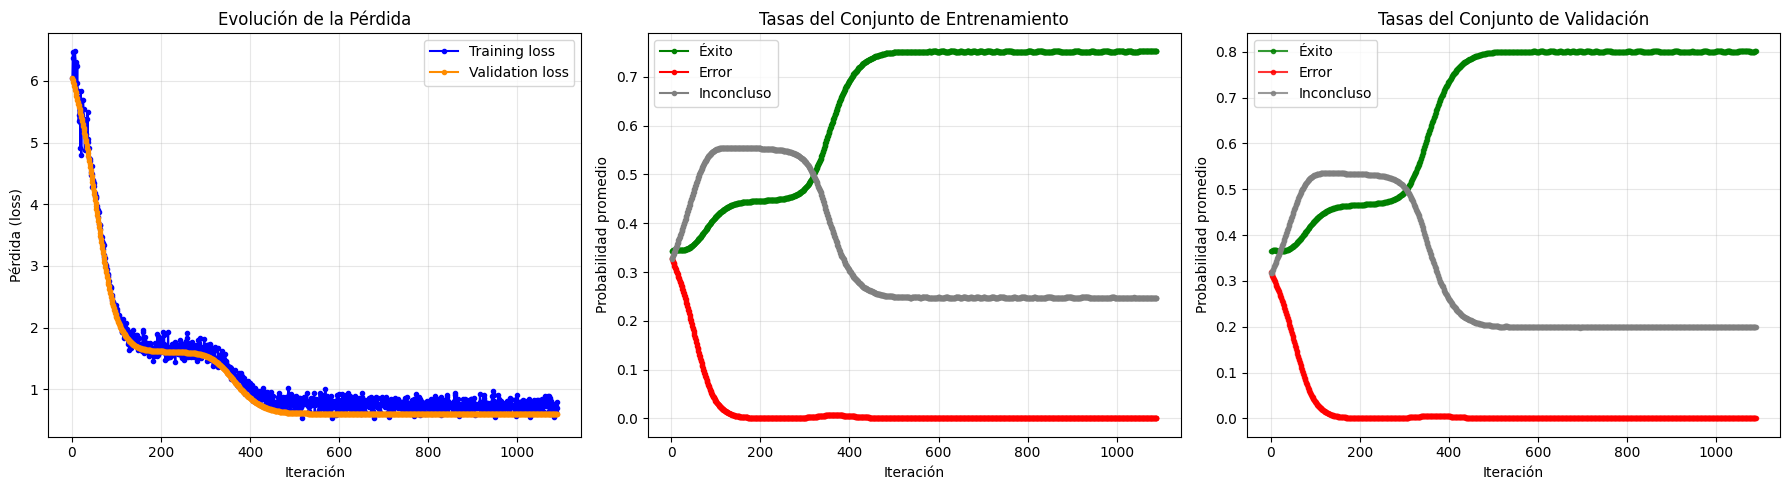

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

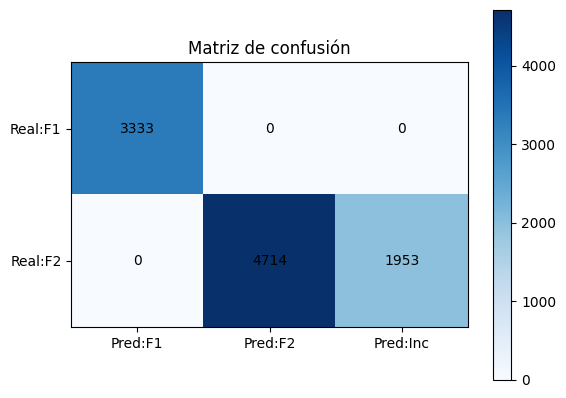

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
